A faire

1) Il faut entrainer le classieur sur les donnée de train_augmenter qui doivent faire la taille de notre fenetre glissante
2) Pour savoir la taille de notre fenetre glissante, Massyle a fait la moyenne et la medianne des annotations
3) Nos images de base doivent aussi toutes avoir la meme dimension, qui sera :

4) La taille de la fenetre glissante sera

5) Pour les images negatif lors de l'augmentation, il faut selectionner des parties de l'image qui correspondent à la taille de la fenetre qu'on avait décidé

# Code d'initialisation

In [ ]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
import os

In [ ]:
# save path to use it easily in the rest of the code /content/drive/MyDrive/detection_ecocup_project/
save_path = "/content/drive/MyDrive/detection_ecocup_project/"


In [ ]:
f_labels = [f for f in os.listdir(os.path.join("/content/drive/MyDrive/detection_ecocup_project/train", "labels_csv")) if f.endswith(".csv")]

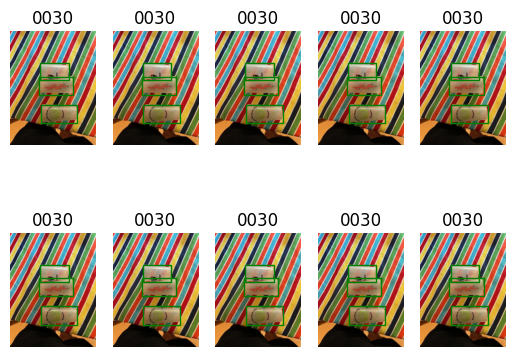

In [ ]:
# Affiche au hasard des images positives de l'ensemble d'apprentissage
fig, axs = plt.subplots(2, 5)
for ax in axs.ravel():
    k = 12
    img = plt.imread(os.path.join(save_path, "train", "images", "pos", f_labels[k][:-4] + ".jpg"))
    bbox = np.loadtxt(os.path.join(save_path,"train", "labels_csv", f_labels[k]), delimiter=",")
    if bbox.ndim == 1:
        bbox = [bbox]

    ax.axis('off')
    ax.set_title(f_labels[k][:-4])
    ax.imshow(img)
    for bb in bbox:
        rect = patches.Rectangle((bb[1], bb[0]), bb[3], bb[2], linewidth=1,
                                 edgecolor='r' if bb[4] > 0 else 'g', facecolor='none')
        ax.add_patch(rect)
plt.show()

In [ ]:
# Affichage statistiques

# TODO:
# nombre d'écocups pour différentes tailles de boîtes
# détail nombre d'ecocups pour chaque image

# Stats fichiers
img_train_pos = [f for f in os.listdir(os.path.join(save_path,"train", "images", "pos")) if f.endswith(".jpg")]
img_train_neg = [f for f in os.listdir(os.path.join(save_path,"train", "images", "neg")) if f.endswith(".jpg")]
img_test = [f for f in os.listdir(os.path.join(save_path,"test")) if f.endswith(".jpg")]

nb_img_train_pos = len(img_train_pos)
nb_img_train_neg = len(img_train_neg)
nb_img_train = nb_img_train_pos + nb_img_train_neg
nb_img_test = len(img_test)

# Stats annotations
all_bbox = None
for csv in f_labels:
    bbox = np.loadtxt(os.path.join(save_path,"train", "labels_csv", csv), delimiter=",")
    if bbox.ndim == 1:
        bbox = [bbox]
    if all_bbox is None:
        all_bbox = np.array(bbox)
    else:
        all_bbox = np.vstack((all_bbox,np.array(bbox)))
nb_ecocup_train = all_bbox.shape[0]
nb_ecocup_train_0 = np.count_nonzero(all_bbox[:,4] == 0)
nb_ecocup_train_1 = np.count_nonzero(all_bbox[:,4] == 1)


print("Quelques statistiques :")
print("  TRAIN")
print("Nombres d'images train = {}, dont {} pos et {} neg".format(nb_img_train, nb_img_train_pos, nb_img_train_neg))
print("Nombres de fichiers d'annotations train = {} (pour {} images pos ; doivent ếtre égaux))".format(len(f_labels), nb_img_train_pos))
print("Nombre d'objets train = {}, dont {} standards et {} difficiles".format(nb_ecocup_train, nb_ecocup_train_0, nb_ecocup_train_1))
print("  TEST")
print("Nombre d'images test = {}".format(nb_img_test))

Quelques statistiques :
  TRAIN
Nombres d'images train = 735, dont 313 pos et 422 neg
Nombres de fichiers d'annotations train = 313 (pour 313 images pos ; doivent ếtre égaux))
Nombre d'objets train = 505, dont 422 standards et 83 difficiles
  TEST
Nombre d'images test = 82


# Il faut choisir la taille de notre classifieur, pour cela, nous allons faire une analyse statistique sur la taille de nos bounding boxs et sur la taille de nos images positives dans le dossier train

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm

# ——————————————————————————
# À MODIFIER : chemin racine de votre projet
# ——————————————————————————
BASE_PATH  = save_path  # ex. "/chemin/vers/votre/projet"
IN_IMG_POS = os.path.join(BASE_PATH, 'train/images/pos')
IN_LABELS  = os.path.join(BASE_PATH, 'train/labels_csv')

# ——————————————————————————
# 1) Collecte des tailles d’images positives
# ——————————————————————————
image_stats = []   # va contenir {'filename', 'height', 'width'}
for fname in tqdm(os.listdir(IN_IMG_POS), desc="Collecte tailles images"):
    if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    img_path = os.path.join(IN_IMG_POS, fname)
    img = cv2.imread(img_path)
    if img is None:
        continue

    h_img, w_img = img.shape[:2]
    image_stats.append({
        'filename': fname,
        'height':   int(h_img),
        'width':    int(w_img)
    })

# ——————————————————————————
# 2) Collecte des dimensions des bounding boxes
# ——————————————————————————
bbox_records = []  # contiendra {'filename', 'bbox_height', 'bbox_width'}
for fname in tqdm(os.listdir(IN_IMG_POS), desc="Collecte dimensions bboxes"):
    if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    name       = os.path.splitext(fname)[0]
    label_path = os.path.join(IN_LABELS, f"{name}.csv")
    if not os.path.exists(label_path):
        continue

    b = np.loadtxt(label_path, delimiter=',')
    if b.ndim == 1:
        b = b[np.newaxis, :]  # si une seule bbox

    for row in b:
        _, _, bh, bw, _ = row
        bbox_records.append({
            'filename':    fname,
            'bbox_height': float(bh),
            'bbox_width':  float(bw)
        })

# ——————————————————————————
# 3) Conversion en DataFrame pandas
# ——————————————————————————
df_img  = pd.DataFrame(image_stats)
df_bbox = pd.DataFrame(bbox_records)

# ——————————————————————————
# 4) Statistiques descriptives sur les images
# ——————————————————————————
print("========================================")
print("STATISTIQUES SUR LES IMAGES POSITIVES")
print("========================================\n")
if not df_img.empty:
    stats_images = df_img[['height', 'width']].describe()
    print(stats_images)
else:
    print("Aucune image positive trouvée ou lisible.")

# ——————————————————————————
# 5) Statistiques descriptives sur les bounding boxes
# ——————————————————————————
print("\n\n========================================")
print("STATISTIQUES SUR LES BOUNDING BOXES")
print("========================================\n")
if not df_bbox.empty:
    stats_bboxes = df_bbox[['bbox_height', 'bbox_width']].describe()
    print(stats_bboxes)
else:
    print("Aucune bounding box trouvée ou fichier labels manquant.")

# ——————————————————————————
# 6) PROPORTION DES BOUNDING BOXES PAR IMAGE (NOMBRE)
# ——————————————————————————
print("\n\n========================================")
print("PROPORTION DES BOUNDING BOXES PAR IMAGE (NOMBRE)")
print("========================================\n")

if not df_img.empty:
    # A) On calcule le nombre de bboxes pour chaque image
    if not df_bbox.empty:
        bbox_counts = df_bbox.groupby('filename').size().reset_index(name='bbox_count')
    else:
        bbox_counts = pd.DataFrame(columns=['filename', 'bbox_count'])

    df_counts = df_img[['filename']].merge(bbox_counts, on='filename', how='left')
    df_counts['bbox_count'] = df_counts['bbox_count'].fillna(0).astype(int)

    # B) Statistiques descriptives sur bbox_count
    stats_per_image = df_counts['bbox_count'].describe()
    print("Nombre de bounding boxes par image (statistiques) :\n")
    print(stats_per_image)

    # C) Ratio global (total_bboxes / total_images)
    total_images = len(df_img)
    total_bboxes = len(df_bbox)
    ratio_global = total_bboxes / total_images if total_images > 0 else float('nan')
    print(f"\nTotal d’images : {total_images}")
    print(f"Total de bounding boxes : {total_bboxes}")
    print(f"Ratio global (bboxes / images) : {ratio_global:.3f}")
else:
    print("Impossible de calculer la proportion car aucune image positive n'a été trouvée.")

# ——————————————————————————
# 7) PROPORTION DES BOUNDING BOXES PAR RAPPORT À L’IMAGE (HAUTEUR & LARGEUR)
# ——————————————————————————
print("\n\n========================================")
print("PROPORTION DES BOUNDING BOXES PAR RAPPORT À L’IMAGE (HAUTEUR & LARGEUR)")
print("========================================\n")
if not df_bbox.empty and not df_img.empty:
    # A) On fusionne df_bbox et df_img pour récupérer height/width de l’image
    df_merge = df_bbox.merge(
        df_img[['filename', 'height', 'width']],
        on='filename',
        how='left'
    )

    # B) Calcul des ratios séparés
    #    - ratio_height : bbox_height / image_height
    #    - ratio_width  : bbox_width  / image_width
    df_merge['ratio_height'] = df_merge['bbox_height'] / df_merge['height']
    df_merge['ratio_width']  = df_merge['bbox_width']  / df_merge['width']

    # C) Statistiques descriptives sur ratio_height et ratio_width
    stats_ratio_height = df_merge['ratio_height'].describe()
    stats_ratio_width  = df_merge['ratio_width'].describe()

    print("=== Statistiques sur ratio_height (bbox_height / image_height) ===\n")
    print(stats_ratio_height)

    print("\n=== Statistiques sur ratio_width (bbox_width / image_width) ===\n")
    print(stats_ratio_width)

    # D) Affirmation de la proportion moyenne en pourcentage
    mean_ratio_h = stats_ratio_height.loc['mean']
    mean_ratio_w = stats_ratio_width.loc['mean']
    print(f"\nEn moyenne, une bbox fait {mean_ratio_h * 100:.2f}% de la hauteur de l'image.")
    print(f"En moyenne, une bbox fait {mean_ratio_w * 100:.2f}% de la largeur de l'image.")
else:
    print("Impossible de calculer les proportions : soit il n'y a pas de bbox, soit pas d'image positive.")

# ——————————————————————————
# FIN DU SCRIPT
# ——————————————————————————


# Stratégie pour la classification et la detection

## 1. Prétraitement pour la classification

Afin de définir une taille d’entrée adaptée pour notre classifieur, nous avons dans un premier temps analysé les dimensions des bounding boxes extraites.

Plutôt que d’utiliser la moyenne brute (372 × 242), fortement influencée par quelques très grandes bounding boxes (jusqu’à 2900 × 1865), nous avons choisi de nous appuyer sur la **médiane** des dimensions, soit **313 × 186 pixels**. Cette valeur est plus robuste face aux outliers et représente mieux la majorité des exemples : 50 % des bounding boxes font au moins cette taille.

Nous avons donc testé un premier pipeline avec une **taille d’entrée fixée à 313 × 186**. Chaque bounding box était redimensionnée à cette taille (avec préservation du ratio et ajout éventuel de padding).

Cependant, les résultats obtenus avec cette taille se sont révélés **nettement inférieurs** à ceux obtenus avec une taille plus compacte, notamment **64 × 128**. Plusieurs facteurs peuvent expliquer cette baisse de performance :
- Le redimensionnement à une taille aussi grande dilue le signal utile et introduit du bruit.
- Le modèle n’est pas optimisé pour gérer une telle résolution.
- L’augmentation de la taille d’entrée complique l’apprentissage sans apporter de gain significatif.

En conséquence, nous avons décidé de **revenir à une taille d’entrée de 64 × 128 pixels**, plus standard, plus rapide à traiter, et donnant de meilleurs résultats empiriques. Cette taille est aussi bien connue pour fonctionner efficacement dans des tâches de détection similaires, comme la détection de piétons.

---

## 2. Stratégie de détection par fenêtres glissantes (sliding windows)

1. **Taille initiale de la fenêtre**  
   - On fixera la fenêtre à 25 % de la hauteur d’image × 17 % de la largeur d’image (ratio_height_start = 0,25, ratio_width_start = 0,17).  
   - En moyenne, une bbox représente 29 % de la hauteur et 22 % de la largeur de l’image, mais on s’appuie plutôt sur la médiane (25,5 % et 17,8 %).

2. **Échelles successives**  
   - On réduira la fenêtre jusqu’à atteindre 15 % × 10 % (ratio_height_end = 0,15, ratio_width_end = 0,10).  
   - Réductions par paliers de 5 % :  
     - Hauteur : 25 % → 20 % → 15 %  
     - Largeur : 17 % → 13 % → 10 %

3. **Pas de déplacement (step size)**  
   - Pour chaque échelle, décaler la fenêtre afin de couvrir l’image avec un chevauchement raisonnable.  
   - Par exemple, un pas égal à la moitié de la largeur/hauteur de la fenêtre correspondante maximise la probabilité de recouvrir l’objet.

4. **Rapports d’aspect variés**  
   - Sur chaque échelle, générer au minimum trois ratios d’aspect, basés sur les données observées :  
     1. **Ratio médian** ≈ 1,68 (313 / 186)  
     2. **Ratio 75ᵉ percentile** ≈ 1,51 (454 / 300)  
     3. **Ratio carré** ≈ 1,00 (pour objets presque carrés)  
   - Ces formes seront affinées ultérieurement si nécessaire.  
   - **Toutes les fenêtres candidates sont ensuite redimensionnées à 64 × 128 pixels avant classification.**

---

## 3. Recherche sélective (Selective Search)

- En complément du sliding window, appliquer la recherche sélective pour proposer des régions candidates :  
  - Segmenter l’image en régions homogènes, puis regrouper ces régions pour générer des propositions de bboxes.  
  - Filtrer ces propositions selon un score de similarité couleur/texture.  
  - Ne retenir que les **~1000 meilleures régions** pour l’étape de classification.  
  - **Chaque région est redimensionnée à 64 × 128 pixels pour correspondre à l’entrée du classifieur.**

---

## 4. Formes variées de fenêtres pour la détection

- Sur chaque échelle du sliding window, utiliser au minimum trois rapports d’aspect :  
  1. Ratio « large » (~1,7)  
  2. Ratio « moyen » (~1,5)  
  3. Ratio « carré » (~1,0)

- Ajuster ces ratios en fonction des performances observées :  
  - Si les bboxes réelles sont plus larges que hautes (ou inversement), ajuster en conséquence.

---

## 5. Pipeline résumé

1. **Extraction des bboxes**  
   - Via **Selective Search** + **Sliding Windows** (multi-échelle / multi-ratio).

2. **Redimensionnement**  
   - Chaque bbox candidate est redimensionnée à **64 × 128 px** avant classification.

3. **Classification**  
   - Chaque région candidate est classée (positif / négatif).

4. **Non-Maximum Suppression (NMS)**  
   - Fusionner les bboxes fortement chevauchantes détectant le même objet.

---

> Cette stratégie intègre des fenêtres glissantes multi-tailles et multi-ratios, associées à la recherche sélective, avec un redimensionnement uniforme à 64 × 128 pixels. Ce choix d’entrée, plus compact que la médiane initiale, s’est avéré plus efficace en pratique.


# Augmentation de nos données

Augmentations géométriques et photométriques

Synthèse d’exemples négatifs

le code qui suit va generer des images negatives à partir d'images positives

In [ ]:
#!pip install albumentations==1.2.1 opencv-python-headless --quiet

Code pour l'augmentation des données :

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
import random

# -----------------------------------
#   Paramètres et chemins
# -----------------------------------
# À adapter à votre arborescence
BASE_PATH = save_path  # Remplace 'save_path' par ton chemin absolu si nécessaire

IN_IMG_POS = os.path.join(BASE_PATH, 'train/images/pos')
IN_IMG_NEG = os.path.join(BASE_PATH, 'train/images/neg')
IN_LABELS  = os.path.join(BASE_PATH, 'train/labels_csv')
OUT_POS    = os.path.join(BASE_PATH, 'train_augmenter/images/pos')
OUT_NEG    = os.path.join(BASE_PATH, 'train_augmenter/images/neg')

TARGET_H, TARGET_W = 128, 64

for d in [OUT_POS, OUT_NEG]:
    os.makedirs(d, exist_ok=True)

# -----------------------------------
#   Chargement des bounding boxes
# -----------------------------------
def load_bboxes(path):
    b = np.loadtxt(path, delimiter=',')
    if b.ndim == 1:
        b = b[np.newaxis, :]
    return pd.DataFrame(b, columns=['ymin','xmin','h','w','diff'])

# -----------------------------------
#   Écriture sécurisée d’un patch
# -----------------------------------
def safe_write(img, path):
    if img is None or img.size == 0 or img.shape[0] == 0 or img.shape[1] == 0:
        print(f"Attention : Tentative d'écriture d'une image vide/invalide à {path}")
        return False
    return cv2.imwrite(path, img)

# -----------------------------------
#   Transformations pour positifs
# -----------------------------------
def flip_horizontal(img):
    return cv2.flip(img, 1)

def adjust_brightness(img, factor=1.2):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] * factor, 0, 255)
    return cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)

POS_TRANSFORMS = [
    ('flip', flip_horizontal),
    ('bright', adjust_brightness),
]

# -----------------------------------
#   Calcul des échelles pour la pyramide
# -----------------------------------
r_h_min, r_h_max = 0.10, 0.50
r_w_min, r_w_max = 0.05, 0.35
num_scales = 5

def compute_scales(orig_H, orig_W):
    s_h_min = TARGET_H / (r_h_max * orig_H)
    s_h_max = TARGET_H / (r_h_min * orig_H)
    s_w_min = TARGET_W / (r_w_max * orig_W)
    s_w_max = TARGET_W / (r_w_min * orig_W)

    s_min = max(s_h_min, s_w_min)
    s_max = min(s_h_max, s_w_max)

    if s_min > s_max:
        return []

    return list(np.linspace(s_min, s_max, num_scales))

stride_x = TARGET_W // 2
stride_y = TARGET_H // 2

# -----------------------------------
# 1. Charger positifs + bboxes
# -----------------------------------
pos_files = [
    f for f in os.listdir(IN_IMG_POS)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
]

pos_bboxes_dict = {}
for fname in pos_files:
    name, _ = os.path.splitext(fname)
    label_path = os.path.join(IN_LABELS, f'{name}.csv')
    if not os.path.exists(label_path):
        continue
    df = load_bboxes(label_path)
    rects = []
    for row in df.itertuples(index=False):
        ymin, xmin, h, w, _ = row
        x1, y1 = int(xmin), int(ymin)
        x2, y2 = int(xmin + w), int(ymin + h)
        rects.append((x1, y1, x2, y2))
    pos_bboxes_dict[name] = rects

# -----------------------------------
# 2. Positifs (crop, aug, rot + aug)
# -----------------------------------
print("=== Génération des positifs avec augmentation ===")
for fname in tqdm(pos_files, desc='Positifs exactes'):
    name, ext = os.path.splitext(fname)
    img = cv2.imread(os.path.join(IN_IMG_POS, fname))
    if img is None or name not in pos_bboxes_dict:
        continue

    H, W = img.shape[:2]
    for idx, (x1, y1, x2, y2) in enumerate(pos_bboxes_dict[name]):
        x1c, y1c = max(0, x1), max(0, y1)
        x2c, y2c = min(W, x2), min(H, y2)

        if x2c <= x1c or y2c <= y1c:
            continue

        crop = img[y1c:y2c, x1c:x2c]
        crop_resized = cv2.resize(crop, (TARGET_W, TARGET_H))

        base = f'{name}_obj{idx}'
        safe_write(crop_resized, os.path.join(OUT_POS, base + ext))

        for tname, tf in POS_TRANSFORMS:
            aug = tf(crop_resized)
            if aug is None or aug.size == 0:
                continue
            aug_resized = cv2.resize(aug, (TARGET_W, TARGET_H))
            safe_write(aug_resized, os.path.join(OUT_POS, f'{base}_{tname}' + ext))

        # Rotation 180°
        rotated = cv2.rotate(crop_resized, cv2.ROTATE_180)
        safe_write(rotated, os.path.join(OUT_POS, f'{base}_rot180' + ext))

        for tname, tf in POS_TRANSFORMS:
            aug_rot = tf(rotated)
            if aug_rot is None or aug_rot.size == 0:
                continue
            aug_rot_resized = cv2.resize(aug_rot, (TARGET_W, TARGET_H))
            safe_write(aug_rot_resized, os.path.join(OUT_POS, f'{base}_rot180_{tname}' + ext))

# -----------------------------------
# 3. Négatifs pyramidaux
# -----------------------------------
print("=== Génération des négatifs pyramidaux ===")
neg_patch_count = 0

# a) depuis IN_IMG_NEG
neg_files = [f for f in os.listdir(IN_IMG_NEG) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
for fname in tqdm(neg_files, desc='Neg pyramide (NEG)'):
    img = cv2.imread(os.path.join(IN_IMG_NEG, fname))
    if img is None:
        continue

    orig_H, orig_W = img.shape[:2]
    scales = compute_scales(orig_H, orig_W)
    candidates = []

    for si, s in enumerate(scales):
        new_H, new_W = int(orig_H * s), int(orig_W * s)
        if new_H < TARGET_H or new_W < TARGET_W:
            continue

        resized = cv2.resize(img, (new_W, new_H))
        for y in range(0, new_H - TARGET_H + 1, stride_y):
            for x in range(0, new_W - TARGET_W + 1, stride_x):
                candidates.append((si, x, y, resized))

    sampled = random.sample(candidates, min(100, len(candidates)))

    for si, x, y, resized in sampled:
        patch = resized[y:y + TARGET_H, x:x + TARGET_W]
        name_part, ext_part = os.path.splitext(fname)
        out_name = f'neg_pyrFromNeg_{name_part}_s{si}_patch{neg_patch_count}'
        safe_write(patch, os.path.join(OUT_NEG, out_name + ext_part))
        neg_patch_count += 1

# b) depuis IN_IMG_POS (zones hors bboxes)
for fname in tqdm(pos_files, desc='Neg pyramide (POS)'):
    name, ext = os.path.splitext(fname)
    img = cv2.imread(os.path.join(IN_IMG_POS, fname))
    if img is None or name not in pos_bboxes_dict:
        continue

    orig_H, orig_W = img.shape[:2]
    rects = pos_bboxes_dict[name]
    scales = compute_scales(orig_H, orig_W)
    candidates = []

    for si, s in enumerate(scales):
        new_H, new_W = int(orig_H * s), int(orig_W * s)
        if new_H < TARGET_H or new_W < TARGET_W:
            continue

        resized = cv2.resize(img, (new_W, new_H))
        scaled_rects = [(int(x1*s), int(y1*s), int(x2*s), int(y2*s)) for (x1,y1,x2,y2) in rects]

        for y in range(0, new_H - TARGET_H + 1, stride_y):
            for x in range(0, new_W - TARGET_W + 1, stride_x):
                patch_box = (x, y, x + TARGET_W, y + TARGET_H)
                if all((max(0, min(x+TARGET_W, bx2) - max(x, bx1)) *
                        max(0, min(y+TARGET_H, by2) - max(y, by1)) == 0)
                       for bx1, by1, bx2, by2 in scaled_rects):
                    candidates.append((si, x, y, resized))

    sampled = random.sample(candidates, min(100, len(candidates)))

    for si, x, y, resized in sampled:
        patch = resized[y:y + TARGET_H, x:x + TARGET_W]
        out_name = f'neg_pyrFromPos_{name}_s{si}_patch{neg_patch_count}'
        safe_write(patch, os.path.join(OUT_NEG, out_name + ext))
        neg_patch_count += 1

print("=== Génération complète terminée ===")


In [ ]:
import os

# pour compter le nombre d'images
folder_path = "/content/drive/MyDrive/detection_ecocup_project/train_augmenter/images/pos"

# Liste des extensions d'images acceptées
image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']

# Comptage des images
image_count = 0
for filename in os.listdir(folder_path):
    if any(filename.lower().endswith(ext) for ext in image_extensions):
        image_count += 1

print(f"Nombre d'images pos dans le dossier : {image_count}")

# pareil mais pour le nb d'images neg
folder_path = "/content/drive/MyDrive/detection_ecocup_project/train_augmenter/images/neg"

# Comptage des images
image_count = 0
for filename in os.listdir(folder_path):
    if any(filename.lower().endswith(ext) for ext in image_extensions):
        image_count += 1

print(f"Nombre d'images neg dans le dossier : {image_count}")


# HOG + SVM

## HOG

In [ ]:
import os
import cv2
import numpy as np
import random
from skimage.feature import hog, local_binary_pattern
from tqdm import tqdm

# -----------------------------------
# ❷ Définition de HOGExtractor adapté à 64×128
#    + HOG sur chaque canal couleur
#    + Histogrammes HSV
#    + Descripteur LBP
# -----------------------------------
class HOGExtractor:
    def __init__(self,
                 win_size=(64, 128),     # (width, height)
                 block_size=(16, 16),
                 block_stride=(8, 8),
                 cell_size=(8, 8),
                 orientations=9,
                 h_bins=50,              # nombre de bins pour Hue
                 s_bins=60,              # nombre de bins pour Saturation
                 lbp_P=8,                # points pour LBP
                 lbp_R=1):               # rayon pour LBP
        self.win_size = win_size
        self.block_size = block_size
        self.block_stride = block_stride
        self.cell_size = cell_size
        self.orientations = orientations
        self.h_bins = h_bins
        self.s_bins = s_bins
        self.lbp_P = lbp_P
        self.lbp_R = lbp_R

    def extract(self, img):
        # 1. redimensionnement
        img_resized = cv2.resize(img, self.win_size)

        # 2. HOG sur chaque canal B, G, R
        hog_feats = []
        for channel in cv2.split(img_resized):
            feats = hog(
                channel,
                orientations=self.orientations,
                pixels_per_cell=self.cell_size,
                cells_per_block=(self.block_size[0] // self.cell_size[0],
                                 self.block_size[1] // self.cell_size[1]),
                block_norm='L2-Hys',
                transform_sqrt=True,
                feature_vector=True
            )
            hog_feats.append(feats)
        hog_features = np.concatenate(hog_feats)

        # 3. Histogrammes HSV (teinte et saturation)
        hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)
        h_hist = cv2.calcHist([hsv], [0], None, [self.h_bins], [0, 180]).flatten()
        s_hist = cv2.calcHist([hsv], [1], None, [self.s_bins], [0, 256]).flatten()
        # normalisation L1
        h_hist = h_hist / (h_hist.sum() + 1e-7)
        s_hist = s_hist / (s_hist.sum() + 1e-7)
        hsv_features = np.concatenate([h_hist, s_hist])

        # 4. Descripteur LBP sur le gris
        gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        lbp = local_binary_pattern(gray, self.lbp_P, self.lbp_R, method='uniform')
        n_bins = int(lbp.max() + 1)
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= (lbp_hist.sum() + 1e-7)

        # 5. Concaténation de tous lescripteurs
        features = np.concatenate([hog_features, hsv_features, lbp_hist])
        return features

# -----------------------------------
# ❸ Répertoires d’images à traiter
# -----------------------------------
BASE = '/content/drive/MyDrive/detection_ecocup_project/train_augmenter/images'
POS_FOLDERS = [os.path.join(BASE, 'pos')]
NEG_FOLDERS = [os.path.join(BASE, 'neg')]

# Nombre de négatifs à échantillonner
NEG_SAMPLE_SIZE = 3000

# -----------------------------------
# ❹ Extraction des features batch
# -----------------------------------
hog_ext = HOGExtractor()
feats, labels = [], []

print("=== Extraction des features pour les exemples négatifs (échantillonnés) ===")
for folder in tqdm(NEG_FOLDERS, desc="Dossier NEG"):
    all_neg = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    sampled_neg = all_neg if len(all_neg) <= NEG_SAMPLE_SIZE else random.sample(all_neg, NEG_SAMPLE_SIZE)
    for fname in tqdm(sampled_neg, desc=f"Sampled from {os.path.basename(folder)}", leave=False):
        img = cv2.imread(os.path.join(folder, fname))
        if img is None:
            continue
        try:
            feats.append(hog_ext.extract(img))
            labels.append(0)
        except Exception as e:
            print(f"  → Skip {fname}: {e}")

print("=== Extraction des features pour les exemples positifs ===")
for folder in tqdm(POS_FOLDERS, desc="Dossier POS"):
    for fname in tqdm(os.listdir(folder), desc=os.path.basename(folder), leave=False):
        if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        img = cv2.imread(os.path.join(folder, fname))
        if img is None:
            continue
        try:
            feats.append(hog_ext.extract(img))
            labels.append(1)
        except Exception as e:
            print(f"  → Skip {fname}: {e}")

# ❺ Conversion en tableaux numpy et affichage
X = np.vstack(feats)
y = np.array(labels)
print(f"Features extraits : X={X.shape}, y={y.shape}")

# ❻ Chemin de sauvegarde sur Google Drive
save_path = '/content/drive/MyDrive/detection_ecocup/hog_hsv_lbp_features.npz'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# ❼ Sauvegarde sur Drive
np.savez(save_path, X=X, y=y)
print(f"✔ Fichier sauvegardé : '{save_path}'")


=== Extraction des features pour les exemples négatifs (échantillonnés) ===


Dossier NEG: 100%|██████████| 1/1 [35:19<00:00, 2119.75s/it]


=== Extraction des features pour les exemples positifs ===


Dossier POS: 100%|██████████| 1/1 [03:28<00:00, 208.45s/it]


Features extraits : X=(5971, 11460), y=(5971,)
✔ Fichier sauvegardé : '/content/drive/MyDrive/detection_ecocup/hog_hsv_lbp_features.npz'


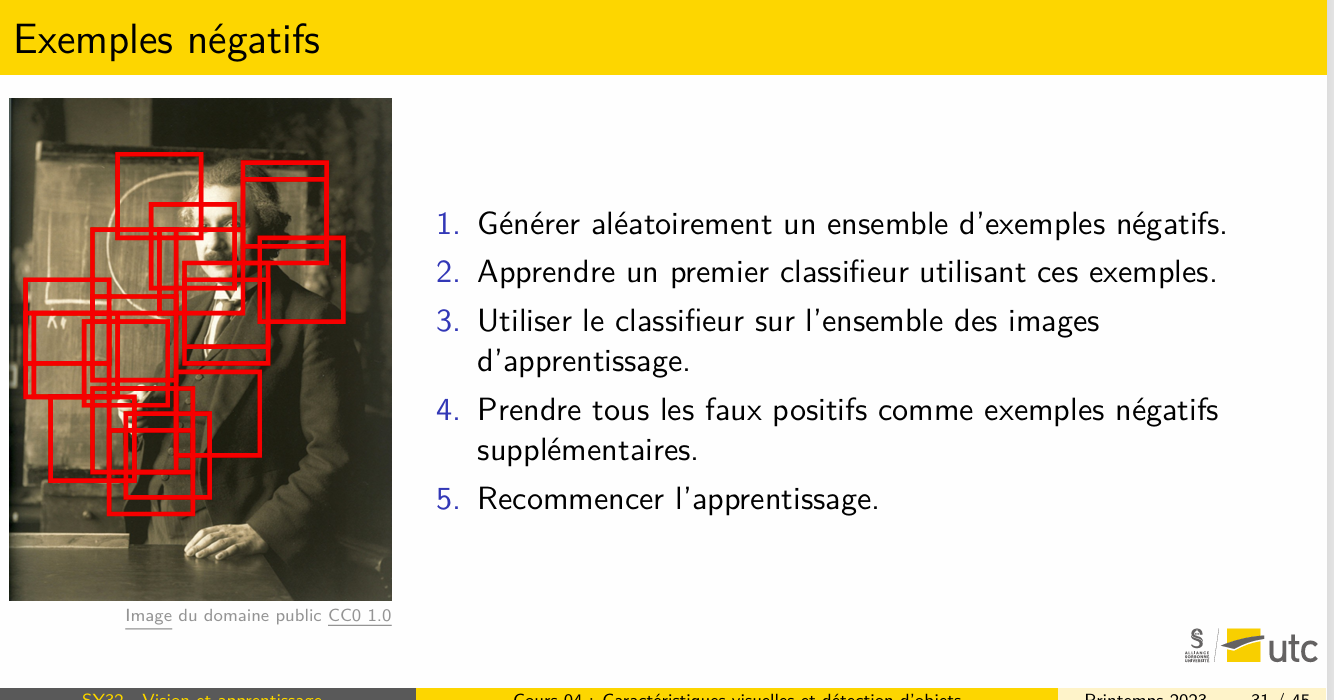

## Analyses

In [ ]:
!pip install ace_tools -q

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


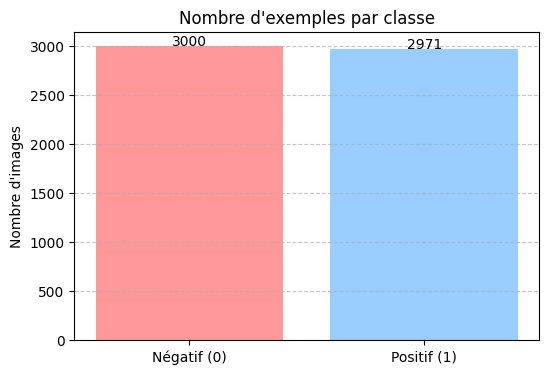

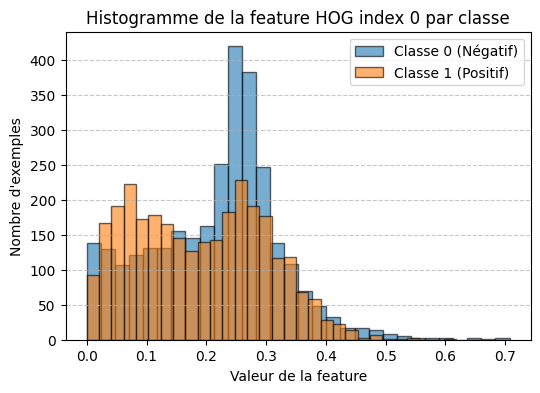

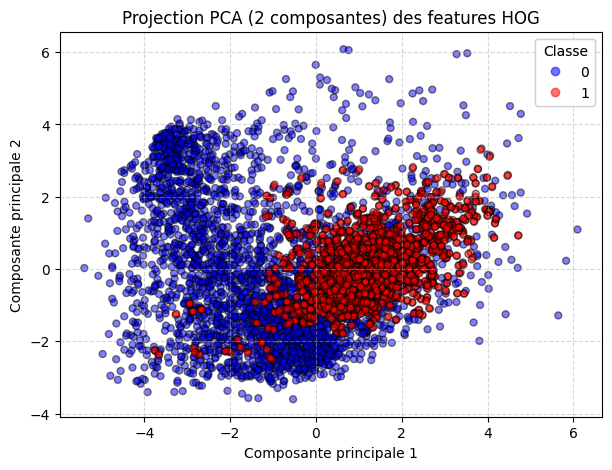

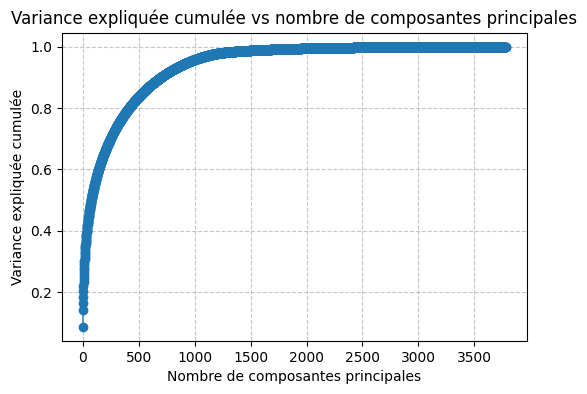

Variance expliquée (%)  Nombre de composantes
0                     40%                     36
1                     45%                     53
2                     50%                     75
3                     55%                    105
4                     60%                    142
5                     64%                    189
6                     70%                    247
7                     75%                    320
8                     80%                    413
9                     84%                    534
10                    89%                    698
11                    94%                    944
12                    99%                   3781

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# If you are in Colab, mount Google Drive, otherwise ignore this step
try:
    from google.colab import drive
    drive.mount('/content/drive')
    npz_path = '/content/drive/MyDrive/detection_ecocup/hog_features.npz'
except ModuleNotFoundError:
    print("Montage de Drive ignoré (pas en Colab). Assurez-vous que 'hog_features.npz' est dans le dossier courant.")
    npz_path = 'hog_features.npz'

from sklearn.decomposition import PCA

# 1) Chargement des données HOG
data = np.load(npz_path)
X = data['X']
y = data['y']

# 2) Affichage de la distribution des labels
label_counts = pd.Series(y).value_counts().sort_index()
fig1, ax1 = plt.subplots(figsize=(6, 4))
ax1.bar(['Négatif (0)', 'Positif (1)'], label_counts.values, color=['#FF9999','#99CCFF'])
ax1.set_title('Nombre d\'exemples par classe')
ax1.set_ylabel('Nombre d\'images')
for i, v in enumerate(label_counts.values):
    ax1.text(i, v + 10, str(v), ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3) Statistiques descriptives par feature et par classe (moyenne & écart-type)
stats = pd.DataFrame({
    'feature_index': np.arange(X.shape[1]),
    'mean_neg': X[y == 0].mean(axis=0),
    'std_neg': X[y == 0].std(axis=0),
    'mean_pos': X[y == 1].mean(axis=0),
    'std_pos': X[y == 1].std(axis=0)
})
# Afficher les 10 premières lignes du DataFrame
# import ace_tools as tools; tools.display_dataframe_to_user(name="Statistiques descriptives HOG (10 premières features)", dataframe=stats.head(10))

# 4) Histogramme comparatif pour une feature (index 0) selon les classes
fig2, ax2 = plt.subplots(figsize=(6, 4))
ax2.hist(X[y == 0, 0], bins=30, alpha=0.6, label='Classe 0 (Négatif)', edgecolor='black')
ax2.hist(X[y == 1, 0], bins=30, alpha=0.6, label='Classe 1 (Positif)', edgecolor='black')
ax2.set_title('Histogramme de la feature HOG index 0 par classe')
ax2.set_xlabel('Valeur de la feature')
ax2.set_ylabel('Nombre d\'exemples')
ax2.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 5) Réduction de dimension par PCA et scatter plot 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

fig3, ax3 = plt.subplots(figsize=(7, 5))
scatter = ax3.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='bwr', alpha=0.5, edgecolor='k', s=25)
ax3.set_title('Projection PCA (2 composantes) des features HOG')
ax3.set_xlabel('Composante principale 1')
ax3.set_ylabel('Composante principale 2')
legend1 = ax3.legend(*scatter.legend_elements(), title="Classe")
ax3.add_artist(legend1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# --- Ajout pour visualiser l'inertie (variance expliquée cumulée) en fonction du nombre de composantes ---
# 1) Calculer la PCA complète (sans réduire d'emblée le nombre de composantes)
pca_full = PCA().fit(X)

# 2) Extraire la variance expliquée (ratio) pour chaque composante
explained_ratio = pca_full.explained_variance_ratio_
cum_explained = np.cumsum(explained_ratio)

# 3) Tracer la variance expliquée cumulée
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, len(cum_explained) + 1), cum_explained, marker='o', linewidth=1)
plt.title("Variance expliquée cumulée vs nombre de composantes principales")
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance expliquée cumulée")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Afficher les resultats dans un tableau aussi

# Définition des seuils d'inertie à partir de 40% (0.40) par pas de 5% (0.05)
thresholds = np.arange(0.40, 1.01, 0.05)  # [0.40, 0.45, ..., 1.00]

# 4) Construire la liste de résultats
results = []
for t in thresholds:
    # np.searchsorted renvoie l'index minimal i tel que cum_explained[i] >= t
    num_components = int(np.searchsorted(cum_explained, t) + 1)
    results.append({
        'Variance expliquée (%)': f"{int(t * 100)}%",
        'Nombre de composantes': num_components
    })

# 5) Transformer en DataFrame et afficher
df_results = pd.DataFrame(results)
display(df_results)

### 🔍 Remarques

Nous avons plus de 3700 dimensions dans nos données (features HOG).  
L'Analyse en Composantes Principales (ACP) peut être utilisée pour réduire la dimension tout en conservant un maximum d'information. Cela peut améliorer les performances de certains algorithmes d'apprentissage, mais pas tous de la même façon.

Voici un résumé de l'intérêt de l'ACP pour les 5 techniques étudiées :

1. **k-plus proches voisins (k-NN)**  
   ✅ *Très utile*  
   → Le k-NN est sensible à la dimension car il utilise une distance entre les points. L'ACP aide à supprimer le bruit et à améliorer la qualité des distances.  
   ➤ Recommandation : garder **80-90 % de la variance**.

2. **Arbre de décision**  
   ❌ *Pas forcément utile*  
   → Larbre choisit automatiquement les variables les plus informatives. Il peut gérer des données très dimensionnelles sans réduction.  
   ➤ ACP rarement nécessaire.

3. **Forêt aléatoire (Random Forest)**  
   ❌ *Peu utile*  
   → Comme les arbres, les forêts aléatoires sélectionnent les features pertinentes. Elles sont peu sensibles à la redondance.  
   ➤ ACP peut être utilisée pour accélérer l'entraînement mais n'apporte pas toujours de gain.

4. **AdaBoost**  
   ⚠️ *Parfois utile*  
   → AdaBoost peut sur-apprendre sur les données bruitées. Une réduction modérée avec l'ACP peut améliorer la robustesse.  
   ➤ Recommandation : garder **70-90 % de la variance**.

5. **Support Vector Machines (SVM)**  
   ✅ *Fortement recommandé*  
   → Les SVM sont sensibles à la dimension. Trop de features peuvent nuire à la stabilité et à la performance. L'ACP permet de simplifier l'espace sans perdre l'information essentielle.  
   ➤ Recommandation : garder **90-95 % de la variance**.


## On train SVM avec 458 cp, puis avec 612, puis avec 862

### SVM_ 550 CP

In [ ]:
import os
import numpy as np
import joblib
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

# -------------------------------------------------------------------
# Pipeline complet en une seule cellule :
#  - Chargement features HOG+HSV+LBP
#  - Split train/val
#  - PCA paramétrable + standardisation
#  - Grid-search SVM (CV-5) + entraînement final
#  - Évaluation + sauvegarde des modèles
# -------------------------------------------------------------------

# 0) Paramètres à modifier
FEATURE_PATH    = '/content/drive/MyDrive/detection_ecocup/hog_hsv_lbp_features.npz'
OUTPUT_DIR      = '/content/drive/MyDrive/detection_ecocup'
TEST_SIZE       = 0.2
RANDOM_STATE    = 42
N_COMPONENTS    = 550              # ← choisissez ici le nombre de CP pour la PCA
GRID_PARAMS     = {
    'C':     [0.1, 1, 10],
    'gamma': ['scale', 0.001, 0.0001]
}

# 1) Chargement des features et labels
print("1) Chargement des features…")
data = np.load(FEATURE_PATH)
X, y = data['X'], data['y']
print(f"   → X = {X.shape}, y = {y.shape}")

# 2) Split train/validation
print("2) Séparation train/val…")
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=RANDOM_STATE
)
print(f"   → Train: {X_train.shape}, Val: {X_val.shape}")

# 3) PCA + Standardisation
print(f"3) PCA({N_COMPONENTS}) + Standardisation…")
pca    = PCA(n_components=N_COMPONENTS, svd_solver='randomized', random_state=RANDOM_STATE)
scaler = StandardScaler()

# Fit-transform train et transform val
X_train_pca   = pca.fit_transform(X_train)
X_val_pca     = pca.transform(X_val)
X_train_scaled = scaler.fit_transform(X_train_pca)
X_val_scaled   = scaler.transform(X_val_pca)

cumvar = np.cumsum(pca.explained_variance_ratio_)[-1]
print(f"   → Variance expliquée cumulée = {cumvar:.4f}")

# Sauvegarde PCA & Scaler
os.makedirs(OUTPUT_DIR, exist_ok=True)
pca_path    = os.path.join(OUTPUT_DIR, f'pca_{N_COMPONENTS}.joblib')
scaler_path = os.path.join(OUTPUT_DIR, f'scaler_pca_{N_COMPONENTS}.joblib')
joblib.dump(pca, pca_path)
joblib.dump(scaler, scaler_path)
print(f"   → PCA enregistrée sous '{pca_path}'")
print(f"   → Scaler enregistré sous '{scaler_path}'")

# 4) Grid-search SVM (CV-5)
print("4) Grid-search SVM (5-fold)…")
param_list = list(ParameterGrid(GRID_PARAMS))
best_score, best_params = -np.inf, None

for params in tqdm(param_list, desc="Grid Search"):
    clf = SVC(kernel='rbf', **params, probability=True, random_state=RANDOM_STATE)
    scores = cross_val_score(clf, X_train_scaled, y_train,
                             cv=5, scoring='average_precision', n_jobs=-1)
    mean_ap = scores.mean()
    tqdm.write(f"   Params={params} → AP CV = {mean_ap:.4f}")
    if mean_ap > best_score:
        best_score, best_params = mean_ap, params

print(f"   → Meilleurs params : {best_params} (AP={best_score:.4f})")

# 5) Entraînement final avec les meilleurs hyperparamètres
print("5) Entraînement final du SVM…")
svm_final = SVC(kernel='rbf', **best_params,
                probability=True, random_state=RANDOM_STATE)
svm_final.fit(X_train_scaled, y_train)

# 6) Évaluation sur le set de validation
print("6) Évaluation sur validation…")
y_pred = svm_final.predict(X_val_scaled)
print("  • Classification report :\n", classification_report(y_val, y_pred))
print("  • Matrice de confusion :\n", confusion_matrix(y_val, y_pred))

# 7) Sauvegarde du modèle final
svm_path = os.path.join(OUTPUT_DIR,
            f'svm_hog_hsv_lbp_pca{N_COMPONENTS}.joblib')
joblib.dump(svm_final, svm_path)
print(f"✔ SVM final enregistré sous '{svm_path}'")


1) Chargement des features…
   → X = (5971, 11460), y = (5971,)
2) Séparation train/val…
   → Train: (4776, 11460), Val: (1195, 11460)
3) PCA(550) + Standardisation…
   → Variance expliquée cumulée = 0.8214
   → PCA enregistrée sous '/content/drive/MyDrive/detection_ecocup/pca_550.joblib'
   → Scaler enregistré sous '/content/drive/MyDrive/detection_ecocup/scaler_pca_550.joblib'
4) Grid-search SVM (5-fold)…


Grid Search:  11%|█         | 1/9 [04:38<37:09, 278.65s/it]

   Params={'C': 0.1, 'gamma': 'scale'} → AP CV = 0.6669


Grid Search:  22%|██▏       | 2/9 [09:29<33:18, 285.54s/it]

   Params={'C': 0.1, 'gamma': 0.001} → AP CV = 0.6999


Grid Search:  33%|███▎      | 3/9 [14:27<29:07, 291.24s/it]

   Params={'C': 0.1, 'gamma': 0.0001} → AP CV = 0.9609


Grid Search:  44%|████▍     | 4/9 [19:02<23:45, 285.07s/it]

   Params={'C': 1, 'gamma': 'scale'} → AP CV = 0.9887


Grid Search:  56%|█████▌    | 5/9 [22:45<17:30, 262.66s/it]

   Params={'C': 1, 'gamma': 0.001} → AP CV = 0.9865


Grid Search:  67%|██████▋   | 6/9 [27:41<13:41, 273.92s/it]

   Params={'C': 1, 'gamma': 0.0001} → AP CV = 0.9675


Grid Search:  78%|███████▊  | 7/9 [32:25<09:14, 277.11s/it]

   Params={'C': 10, 'gamma': 'scale'} → AP CV = 0.9896


Grid Search:  89%|████████▉ | 8/9 [36:24<04:25, 265.21s/it]

   Params={'C': 10, 'gamma': 0.001} → AP CV = 0.9893


Grid Search: 100%|██████████| 9/9 [38:55<00:00, 259.49s/it]


   Params={'C': 10, 'gamma': 0.0001} → AP CV = 0.9809
   → Meilleurs params : {'C': 10, 'gamma': 'scale'} (AP=0.9896)
5) Entraînement final du SVM…
6) Évaluation sur validation…
  • Classification report :
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       600
           1       0.96      0.94      0.95       595

    accuracy                           0.95      1195
   macro avg       0.95      0.95      0.95      1195
weighted avg       0.95      0.95      0.95      1195

  • Matrice de confusion :
 [[578  22]
 [ 35 560]]
✔ SVM final enregistré sous '/content/drive/MyDrive/detection_ecocup/svm_hog_hsv_lbp_pca550.joblib'


In [ ]:
# ------------------------------------
# Évaluation sur l’ensemble Val (modèle déjà sauvegardé)
# ------------------------------------
import joblib
from sklearn.metrics import classification_report, confusion_matrix

# Chemins vers les fichiers nécessaires
svm_path    = '/content/drive/MyDrive/detection_ecocup/svm_hog_pca458_final.joblib'
scaler_path = '/content/drive/MyDrive/detection_ecocup/scaler_pca_458.joblib'
pca_path    = '/content/drive/MyDrive/detection_ecocup/pca_458.joblib'
hog_path    = '/content/drive/MyDrive/detection_ecocup/hog_features.npz'

# Chargement des données
X, y = load_hog_features(hog_path)
_, X_val, _, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Chargement des modèles
svm_final = joblib.load(svm_path)
scaler = joblib.load(scaler_path)
pca = joblib.load(pca_path)

# Transformation PCA + standardisation
X_val_pca = pca.transform(X_val)
X_val_scaled = scaler.transform(X_val_pca)

# Prédiction et évaluation
y_pred = svm_final.predict(X_val_scaled)
print("✔ Rapport de classification :\n", classification_report(y_val, y_pred))
print("✔ Matrice de confusion :\n", confusion_matrix(y_val, y_pred))


Hard negative mining avec seuil = 0.7

In [ ]:
import os
import random
import cv2
import numpy as np
import joblib
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt

# -----------------------------------
# ❶ Définition d'un extracteur HOG
# -----------------------------------
class HOGExtractor:
    def __init__(self,
                 win_size=(64, 128),
                 block_size=(16, 16),
                 block_stride=(8, 8),
                 cell_size=(8, 8),
                 orientations=9):
        self.win_size = win_size
        self.block_size = block_size
        self.block_stride = block_stride
        self.cell_size = cell_size
        self.orientations = orientations

    def extract(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img
        feat = hog(
            gray,
            orientations=self.orientations,
            pixels_per_cell=self.cell_size,
            cells_per_block=(self.block_size[0] // self.cell_size[0],
                             self.block_size[1] // self.cell_size[1]),
            block_norm='L2-Hys',
            transform_sqrt=True,
            feature_vector=True
        )
        return feat

# -----------------------------------
# ❷ Chemins
# -----------------------------------
BASE_AUG      = '/content/drive/MyDrive/detection_ecocup_project/train_augmenter/images'
POS_FOLDER    = os.path.join(BASE_AUG, 'pos')
NEG_FOLDER    = os.path.join(BASE_AUG, 'neg')

PCA_PATH      = '/content/drive/MyDrive/detection_ecocup/pca_458.joblib'
SCALER_PATH   = '/content/drive/MyDrive/detection_ecocup/scaler_pca_458.joblib'
SVM_PATH      = '/content/drive/MyDrive/detection_ecocup/svm_hog_pca458_final.joblib'
HOG_FEAT_NPZ  = '/content/drive/MyDrive/detection_ecocup/hog_features.npz'

# -----------------------------------
# ❸ Chargement PCA, scaler et SVM
# -----------------------------------
pca    = joblib.load(PCA_PATH)
scaler = joblib.load(SCALER_PATH)
svm    = joblib.load(SVM_PATH)

# -----------------------------------
# ❹ Mini hard-negative mining (avec score)
# -----------------------------------
random.seed(42)
hog_ext = HOGExtractor()
neg_files = [f for f in os.listdir(NEG_FOLDER)
             if f.lower().endswith(('.png','.jpg','.jpeg'))]
sampled = random.sample(neg_files, min(40000, len(neg_files)))

hard_neg_feats = []
SCORE_THRESHOLD = 0.7  # seuil de confiance pour retenir un faux positif

for fname in tqdm(sampled, desc="Hard negatives sampling"):
    img = cv2.imread(os.path.join(NEG_FOLDER, fname))
    if img is None:
        continue
    feat = hog_ext.extract(img)
    f_pca    = pca.transform(feat.reshape(1, -1))
    f_scaled = scaler.transform(f_pca)
    pred     = svm.predict(f_scaled)
    score    = svm.decision_function(f_scaled)[0]

    if pred[0] == 1 and score > SCORE_THRESHOLD:
        hard_neg_feats.append(feat)

print(f"→ Faux positifs retenus (score > {SCORE_THRESHOLD}) : {len(hard_neg_feats)}")

# -----------------------------------
# ❺ Préparation des données d’entraînement
# -----------------------------------
data = np.load(HOG_FEAT_NPZ)
X, y = data['X'], data['y']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train_pca    = pca.transform(X_train)
X_train_scaled = scaler.transform(X_train_pca)

if hard_neg_feats:
    H = np.vstack(hard_neg_feats)
    H_pca    = pca.transform(H)
    H_scaled = scaler.transform(H_pca)
    X_train_aug = np.vstack([X_train_scaled, H_scaled])
    y_train_aug = np.hstack([y_train, np.zeros(len(H_scaled), dtype=int)])
else:
    X_train_aug, y_train_aug = X_train_scaled, y_train

# -----------------------------------
# ❻ Réentraînement du SVM
# -----------------------------------
svm.fit(X_train_aug, y_train_aug)

# -----------------------------------
# ❼ Évaluation sur la validation d’origine
# -----------------------------------
X_val_pca    = pca.transform(X_val)
X_val_scaled = scaler.transform(X_val_pca)
y_pred       = svm.predict(X_val_scaled)

# classification report et matrice
report = classification_report(y_val, y_pred, output_dict=True)
cm     = confusion_matrix(y_val, y_pred)

# -----------------------------------
# ❽ Plot des résultats
# -----------------------------------
# 1) Matrice de confusion
plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(cm))
plt.xticks(tick_marks, ['neg','pos'])
plt.yticks(tick_marks, ['neg','pos'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="white" if cm[i, j] > cm.max()/2 else "black")
plt.ylabel('Vraie étiquette')
plt.xlabel('Prédiction')
plt.tight_layout()
plt.show()

# 2) Bar chart des métriques
metrics = ['precision', 'recall', 'f1-score']
labels  = ['neg', 'pos']
x       = np.arange(len(labels))
width   = 0.25

plt.figure(figsize=(6,4))
for i, m in enumerate(metrics):
    vals = [report[label][m] for label in ['0','1']]
    plt.bar(x + i*width, vals, width, label=m)
plt.xticks(x + width, labels)
plt.ylim(0,1)
plt.title("Precision / Recall / F1-score par classe")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------------
# ❾ Sauvegarde (écrasement)
# -----------------------------------
joblib.dump(svm, SVM_PATH)
print(f"✔ Modèle SVM mis à jour et sauvé sous : {SVM_PATH}")


### SVM_ 612 CP

In [ ]:
# -----------------------------------
# Cellule 1 : PCA (fit + sauvegarde)
# -----------------------------------

import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib

# -----------------------------------
# 1) Chargement des features HOG
# -----------------------------------
def load_hog_features(path='/content/drive/MyDrive/detection_ecocup/hog_features.npz'):
    data = np.load(path)
    return data['X'], data['y']

X, y = load_hog_features('/content/drive/MyDrive/detection_ecocup/hog_features.npz')
print(f"Chargé X {X.shape}, y {y.shape}")
# → Par exemple : Chargé X (6475, 30096), y (6475,)

# -----------------------------------
# 2) Séparation train/validation
# -----------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Train: {X_train.shape}, Val: {X_val.shape}")
# → Exemple : Train: (5180, 30096), Val: (1295, 30096)

# ------------------------------------------------
# 3) PCA (612 composantes) appliquée une seule fois
# ------------------------------------------------
n_components = 612  # <-- MODIFIÉ

# Utiliser svd_solver='randomized' pour accélérer la PCA sur de grands tableaux
pca = PCA(n_components=n_components, svd_solver='randomized', random_state=42)

# 3.a) Fit PCA sur X_train
print(f"– Fitting PCA({n_components}) sur X_train …")
X_train_pca = pca.fit_transform(X_train)
X_val_pca   = pca.transform(X_val)

print(f"X_train_pca = {X_train_pca.shape}, X_val_pca = {X_val_pca.shape}")

# Optionnel : afficher la variance expliquée cumulée pour vérifier qu’on a bien assez de variance
explained_ratio = np.cumsum(pca.explained_variance_ratio_)
print(f"– Variance cumulée avec {n_components} comps = {explained_ratio[-1]:.4f}")

# ------------------------------------------------
# 4) Standardisation sur données projetées PCA
# ------------------------------------------------
scaler = StandardScaler()
print("– Standardisation des données PCA …")
X_train_scaled = scaler.fit_transform(X_train_pca)
X_val_scaled   = scaler.transform(X_val_pca)

# ------------------------------------------------
# 5) Sauvegarde : PCA + Scaler
# ------------------------------------------------
# 5.a) Sauvegarde de la PCA
save_pca = f'/content/drive/MyDrive/detection_ecocup/pca_{n_components}.joblib' # <-- MODIFIÉ
joblib.dump(pca, save_pca)
print(f"✔ PCA ({n_components} comps) enregistrée sous '{save_pca}'")

# 5.b) Sauvegarde du Scaler
save_scaler = f'/content/drive/MyDrive/detection_ecocup/scaler_pca_{n_components}.joblib'
joblib.dump(scaler, save_scaler)
print(f"✔ Scaler enregistré sous '{save_scaler}'")

In [ ]:
# -----------------------------------
# Cellule 2 : SVM (chargement PCA/Scaler + grid search + sauvegarde)
# -----------------------------------

import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from tqdm import tqdm

# -----------------------------------
# 1) Chargement des features HOG
# -----------------------------------
def load_hog_features(path='/content/drive/MyDrive/detection_ecocup/hog_features.npz'):
    data = np.load(path)
    return data['X'], data['y']

X, y = load_hog_features('/content/drive/MyDrive/detection_ecocup/hog_features.npz')
print(f"Chargé X {X.shape}, y {y.shape}")

# -----------------------------------
# 2) Séparation train/validation
# -----------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Train: {X_train.shape}, Val: {X_val.shape}")
# → Les mêmes indices que dans la cellule PCA grâce à random_state=42

# ------------------------------------------------
# 3) Chargement de la PCA et du Scaler
# ------------------------------------------------
n_components_to_load = 612 # <-- MODIFIÉ
pca_path    = f'/content/drive/MyDrive/detection_ecocup/pca_{n_components_to_load}.joblib' # <-- MODIFIÉ
scaler_path = f'/content/drive/MyDrive/detection_ecocup/scaler_pca_{n_components_to_load}.joblib'

print("– Chargement de la PCA enregistrée…")
pca = joblib.load(pca_path)

print("– Chargement du Scaler enregistré…")
scaler = joblib.load(scaler_path)

# ------------------------------------------------
# 4) Transformation PCA + Standardisation
# ------------------------------------------------
# On transforme X_train et X_val sans refitter la PCA ni le scaler
print("– Transformation PCA sur X_train et X_val…")
X_train_pca = pca.transform(X_train)
X_val_pca   = pca.transform(X_val)

print("– Standardisation des données PCA…")
X_train_scaled = scaler.transform(X_train_pca)
X_val_scaled   = scaler.transform(X_val_pca)

# ------------------------------------------
# 5) Recherche d’hyperparamètres SVM (CV-5)
# ------------------------------------------
grid_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.001, 0.0001]
}
param_list = list(ParameterGrid(grid_params))

print(f"Nombre de combinaisons de paramètres à tester : {len(param_list)}")
# → 3 × 3 = 9 combinaisons

best_score = -np.inf
best_params = None

print("Début de la recherche manuelle des meilleurs hyperparamètres…")
for params in tqdm(param_list, desc="Grid Search SVM"):
    svm_clf = SVC(kernel='rbf', **params, probability=True, random_state=42)

    # cross_val_score: sur X_train_scaled (déjà standardisé)
    scores = cross_val_score(
        svm_clf,
        X_train_scaled,
        y_train,
        cv=5,
        scoring='average_precision',
        n_jobs=-1
    )
    mean_score = scores.mean()
    tqdm.write(f"Params={params}, AP CV-moyenne={mean_score:.4f}")

    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print(f"\nMeilleurs paramètres trouvés : {best_params} (AP={best_score:.4f})")

# ------------------------------------------------
# 6) Entraînement final du SVM sur tout X_train_scaled
# ------------------------------------------------
print("– Entraînement final du SVM avec les meilleurs paramètres sur tout X_train_scaled …")
svm_final = SVC(kernel='rbf', **best_params, probability=True, random_state=42)
svm_final.fit(X_train_scaled, y_train)
print("Entraînement final du modèle terminé.")

# ------------------------------------
# 7) Évaluation sur l’ensemble Val
# ------------------------------------
y_pred = svm_final.predict(X_val_scaled)
print("Rapport de classification :\n", classification_report(y_val, y_pred))
print("Matrice de confusion :\n", confusion_matrix(y_val, y_pred))

# ------------------------------------------------
# 8) Sauvegarde : SVM final
# ------------------------------------------------
save_svm = f'/content/drive/MyDrive/detection_ecocup/svm_hog_pca{n_components_to_load}_final.joblib' # <-- MODIFIÉ
joblib.dump(svm_final, save_svm)
print(f"✔ SVM final enregistré sous '{save_svm}'")

### SVM_ 862 CP

In [ ]:
# -----------------------------------
# Cellule 1 : PCA (fit + sauvegarde)
# -----------------------------------

import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib

# -----------------------------------
# 1) Chargement des features HOG
# -----------------------------------
def load_hog_features(path='/content/drive/MyDrive/detection_ecocup/hog_features.npz'):
    data = np.load(path)
    return data['X'], data['y']

X, y = load_hog_features('/content/drive/MyDrive/detection_ecocup/hog_features.npz')
print(f"Chargé X {X.shape}, y {y.shape}")
# → Par exemple : Chargé X (6475, 30096), y (6475,)

# -----------------------------------
# 2) Séparation train/validation
# -----------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Train: {X_train.shape}, Val: {X_val.shape}")
# → Exemple : Train: (5180, 30096), Val: (1295, 30096)

# ------------------------------------------------
# 3) PCA (862 composantes) appliquée une seule fois
# ------------------------------------------------
n_components = 862  # <-- MODIFIÉ

# Utiliser svd_solver='randomized' pour accélérer la PCA sur de grands tableaux
pca = PCA(n_components=n_components, svd_solver='randomized', random_state=42)

# 3.a) Fit PCA sur X_train
print(f"– Fitting PCA({n_components}) sur X_train …")
X_train_pca = pca.fit_transform(X_train)  # Résultat shape = (5180, 862)
X_val_pca   = pca.transform(X_val)        # Résultat shape = (1295, 862)

print(f"X_train_pca = {X_train_pca.shape}, X_val_pca = {X_val_pca.shape}")

# Optionnel : afficher la variance expliquée cumulée pour vérifier qu’on a bien assez de variance
explained_ratio = np.cumsum(pca.explained_variance_ratio_)
print(f"– Variance cumulée avec {n_components} comps = {explained_ratio[-1]:.4f}")

# ------------------------------------------------
# 4) Standardisation sur données projetées PCA
# ------------------------------------------------
scaler = StandardScaler()
print("– Standardisation des données PCA …")
X_train_scaled = scaler.fit_transform(X_train_pca)
X_val_scaled   = scaler.transform(X_val_pca)

# ------------------------------------------------
# 5) Sauvegarde : PCA + Scaler
# ------------------------------------------------
# 5.a) Sauvegarde de la PCA
save_pca = '/content/drive/MyDrive/detection_ecocup/pca_862.joblib'  # <-- MODIFIÉ
joblib.dump(pca, save_pca)
print(f"✔ PCA ({n_components} comps) enregistrée sous '{save_pca}'")

# 5.b) Sauvegarde du Scaler
save_scaler = '/content/drive/MyDrive/detection_ecocup/scaler_pca_862.joblib'
joblib.dump(scaler, save_scaler)
print(f"✔ Scaler enregistré sous '{save_scaler}'")

In [ ]:
# -----------------------------------
# Cellule 2 : SVM (chargement PCA/Scaler + grid search + sauvegarde)
# -----------------------------------

import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler  # (on l'importe pour être sûr)
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from tqdm import tqdm

# -----------------------------------
# 1) Chargement des features HOG
# -----------------------------------
def load_hog_features(path='/content/drive/MyDrive/detection_ecocup/hog_features.npz'):
    data = np.load(path)
    return data['X'], data['y']

X, y = load_hog_features('/content/drive/MyDrive/detection_ecocup/hog_features.npz')
print(f"Chargé X {X.shape}, y {y.shape}")

# -----------------------------------
# 2) Séparation train/validation
# -----------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Train: {X_train.shape}, Val: {X_val.shape}")
# → Les mêmes indices que dans la cellule PCA grâce à random_state=42

# ------------------------------------------------
# 3) Chargement de la PCA et du Scaler
# ------------------------------------------------
pca_path    = '/content/drive/MyDrive/detection_ecocup/pca_862.joblib'  # <-- MODIFIÉ
scaler_path = '/content/drive/MyDrive/detection_ecocup/scaler_pca_862.joblib'

print("– Chargement de la PCA enregistrée…")
pca = joblib.load(pca_path)

print("– Chargement du Scaler enregistré…")
scaler = joblib.load(scaler_path)

# ------------------------------------------------
# 4) Transformation PCA + Standardisation
# ------------------------------------------------
# On transforme X_train et X_val sans refitter la PCA ni le scaler
print("– Transformation PCA sur X_train et X_val…")
X_train_pca = pca.transform(X_train)  # shape = (5180, 862)
X_val_pca   = pca.transform(X_val)    # shape = (1295, 862)

print("– Standardisation des données PCA…")
X_train_scaled = scaler.transform(X_train_pca)
X_val_scaled   = scaler.transform(X_val_pca)

# ------------------------------------------
# 5) Recherche d’hyperparamètres SVM (CV-5)
# ------------------------------------------
grid_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.001, 0.0001]
}
param_list = list(ParameterGrid(grid_params))

print(f"Nombre de combinaisons de paramètres à tester : {len(param_list)}")
# → 3 × 3 = 9 combinaisons

best_score = -np.inf
best_params = None

print("Début de la recherche manuelle des meilleurs hyperparamètres…")
for params in tqdm(param_list, desc="Grid Search SVM"):
    svm_clf = SVC(kernel='rbf', **params, probability=True, random_state=42)

    # cross_val_score: sur X_train_scaled (déjà standardisé)
    scores = cross_val_score(
        svm_clf,
        X_train_scaled,
        y_train,
        cv=5,
        scoring='average_precision',
        n_jobs=-1
    )
    mean_score = scores.mean()
    tqdm.write(f"Params={params}, AP CV-moyenne={mean_score:.4f}")

    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print(f"\nMeilleurs paramètres trouvés : {best_params} (AP={best_score:.4f})")

# ------------------------------------------------
# 6) Entraînement final du SVM sur tout X_train_scaled
# ------------------------------------------------
print("– Entraînement final du SVM avec les meilleurs paramètres sur tout X_train_scaled …")
svm_final = SVC(kernel='rbf', **best_params, probability=True, random_state=42)
svm_final.fit(X_train_scaled, y_train)
print("Entraînement final du modèle terminé.")

# ------------------------------------
# 7) Évaluation sur l’ensemble Val
# ------------------------------------
y_pred = svm_final.predict(X_val_scaled)
print("Rapport de classification :\n", classification_report(y_val, y_pred))
print("Matrice de confusion :\n", confusion_matrix(y_val, y_pred))

# ------------------------------------------------
# 8) Sauvegarde : SVM final
# ------------------------------------------------
save_svm = '/content/drive/MyDrive/detection_ecocup/svm_hog_pca862_final.joblib'  # <-- MODIFIÉ
joblib.dump(svm_final, save_svm)
print(f"✔ SVM final enregistré sous '{save_svm}'")

# On applique maintetant le premier classifieur HOG + SVM 458 au données test

In [ ]:
# =========================
# Application du modèle SVM + PCA sur le jeu de test + Visualisation de TOUTES les erreurs
# =========================

import os
import cv2
import joblib
import numpy as np
from skimage.feature import hog
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1) Définir la classe HOGExtractor (identique à l'entraînement)
class HOGExtractor:
    def __init__(self,
                 win_size=(64, 128),
                 block_size=(16, 16),
                 block_stride=(8, 8),
                 cell_size=(8, 8),
                 orientations=9):
        self.win_size = win_size
        self.block_size = block_size
        self.block_stride = block_stride
        self.cell_size = cell_size
        self.orientations = orientations

    def extract(self, img):
        img_resized = cv2.resize(img, self.win_size)
        gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY) if img_resized.ndim == 3 else img_resized
        features = hog(
            gray,
            orientations=self.orientations,
            pixels_per_cell=self.cell_size,
            cells_per_block=(self.block_size[0] // self.cell_size[0], self.block_size[1] // self.cell_size[1]),
            block_norm='L2-Hys',
            transform_sqrt=True,
            feature_vector=True
        )
        return features

# 2) Chemins vers les dossiers de test et les modèles
pos_test_folder = '/content/drive/MyDrive/detection_ecocup_project/images_test/pos'
neg_test_folder = '/content/drive/MyDrive/detection_ecocup_project/images_test/neg'

# <-- MODIFICATION : Chemins vers les objets PCA et Scaler
pca_path    = '/content/drive/MyDrive/detection_ecocup/pca_458.joblib'
scaler_path = '/content/drive/MyDrive/detection_ecocup/scaler_pca_458.joblib'
svm_path    = '/content/drive/MyDrive/detection_ecocup/svm_hog_pca458_final.joblib'

# 3) Extraction HOG sur les images de test
hog_ext = HOGExtractor()
X_test_feats, y_test, img_paths = [], [], []

print("Extraction HOG pour les images test positives...")
for fname in tqdm(os.listdir(pos_test_folder), desc="Test POS"):
    if not fname.lower().endswith(('.png','.jpg','.jpeg')):
        continue
    img_path = os.path.join(pos_test_folder, fname)
    img = cv2.imread(img_path)
    if img is None: continue
    try:
        X_test_feats.append(hog_ext.extract(img))
        y_test.append(1)
        img_paths.append(img_path)
    except Exception as e:
        print(f"  → Skip {fname}: {e}")

print("Extraction HOG pour les images test négatives...")
for fname in tqdm(os.listdir(neg_test_folder), desc="Test NEG"):
    if not fname.lower().endswith(('.png','.jpg','.jpeg')):
        continue
    img_path = os.path.join(neg_test_folder, fname)
    img = cv2.imread(img_path)
    if img is None: continue
    try:
        X_test_feats.append(hog_ext.extract(img))
        y_test.append(0)
        img_paths.append(img_path)
    except Exception as e:
        print(f"  → Skip {fname}: {e}")

# Conversion en numpy arrays
X_test = np.vstack(X_test_feats) if X_test_feats else np.empty((0, 3780))
y_test = np.array(y_test)
print(f"\nJeu de test features HOG: X_test={X_test.shape}, y_test={y_test.shape}")

# 4) Chargement des modèles PCA, Scaler et SVM
print("Chargement des modèles PCA, Scaler et SVM...")
pca_model = joblib.load(pca_path)
scaler_model = joblib.load(scaler_path)
svm_model = joblib.load(svm_path)
print("✔ Modèles chargés.")

# 5) Appliquer les transformations PCA et Scaler <-- MODIFICATION
#    IMPORTANT: On utilise .transform() et non .fit_transform()
print("Application des transformations PCA et Scaler sur les données de test...")
X_test_pca = pca_model.transform(X_test)
X_test_scaled = scaler_model.transform(X_test_pca)
print(f"Shape après PCA + Scaler : {X_test_scaled.shape}")

# 6) Prédictions sur l'ensemble de test transformé <-- MODIFICATION
y_pred = svm_model.predict(X_test_scaled)

# 7) Évaluation
print("\n=== Rapport de classification sur le jeu de test ===")
print(classification_report(y_test, y_pred))
print("=== Matrice de confusion sur le jeu de test ===")
print(confusion_matrix(y_test, y_pred))

# 8) Visualisation de TOUTES les erreurs
fp_indices = np.where((y_pred == 1) & (y_test == 0))[0]
fn_indices = np.where((y_pred == 0) & (y_test == 1))[0]

print(f"\nNombre de Faux Positifs : {len(fp_indices)}")
print(f"Nombre de Faux Négatifs : {len(fn_indices)}\n")

def show_all_errors(indices, title):
    n = len(indices)
    if n == 0:
        print(f"Aucun exemple pour : {title}")
        return
    cols = 5
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3.5 * rows))
    axes = axes.flatten()
    for ax in axes:
        ax.axis('off')
    for i, idx in enumerate(indices):
        img = cv2.imread(img_paths[idx])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img_rgb)
        axes[i].set_title(os.path.basename(img_paths[idx]), fontsize=8)
        axes[i].axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

show_all_errors(fp_indices, title="Toutes les Faux Positifs (prédit=Ecocup, vrai=Non-Ecocup)")
show_all_errors(fn_indices, title="Tous les Faux Négatifs (prédit=Non-Ecocup, vrai=Ecocup)")

# On applique maintetant le premier classifieur HOG + SVM 612 au données test

In [ ]:
# =========================
# Application du modèle SVM + PCA sur le jeu de test + Visualisation de TOUTES les erreurs
# =========================

import os
import cv2
import joblib
import numpy as np
from skimage.feature import hog
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1) Définir la classe HOGExtractor (identique à l'entraînement)
class HOGExtractor:
    def __init__(self,
                 win_size=(64, 128),
                 block_size=(16, 16),
                 block_stride=(8, 8),
                 cell_size=(8, 8),
                 orientations=9):
        self.win_size = win_size
        self.block_size = block_size
        self.block_stride = block_stride
        self.cell_size = cell_size
        self.orientations = orientations

    def extract(self, img):
        img_resized = cv2.resize(img, self.win_size)
        gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY) if img_resized.ndim == 3 else img_resized
        features = hog(
            gray,
            orientations=self.orientations,
            pixels_per_cell=self.cell_size,
            cells_per_block=(self.block_size[0] // self.cell_size[0], self.block_size[1] // self.cell_size[1]),
            block_norm='L2-Hys',
            transform_sqrt=True,
            feature_vector=True
        )
        return features

# 2) Chemins vers les dossiers de test et les modèles
pos_test_folder = '/content/drive/MyDrive/detection_ecocup_project/images_test/pos'
neg_test_folder = '/content/drive/MyDrive/detection_ecocup_project/images_test/neg'

# <-- MODIFICATION : Chemins vers les objets PCA et Scaler
pca_path    = '/content/drive/MyDrive/detection_ecocup/pca_612.joblib'
scaler_path = '/content/drive/MyDrive/detection_ecocup/scaler_pca_612.joblib'
svm_path    = '/content/drive/MyDrive/detection_ecocup/svm_hog_pca612_final.joblib'

# 3) Extraction HOG sur les images de test
hog_ext = HOGExtractor()
X_test_feats, y_test, img_paths = [], [], []

print("Extraction HOG pour les images test positives...")
for fname in tqdm(os.listdir(pos_test_folder), desc="Test POS"):
    if not fname.lower().endswith(('.png','.jpg','.jpeg')):
        continue
    img_path = os.path.join(pos_test_folder, fname)
    img = cv2.imread(img_path)
    if img is None: continue
    try:
        X_test_feats.append(hog_ext.extract(img))
        y_test.append(1)
        img_paths.append(img_path)
    except Exception as e:
        print(f"  → Skip {fname}: {e}")

print("Extraction HOG pour les images test négatives...")
for fname in tqdm(os.listdir(neg_test_folder), desc="Test NEG"):
    if not fname.lower().endswith(('.png','.jpg','.jpeg')):
        continue
    img_path = os.path.join(neg_test_folder, fname)
    img = cv2.imread(img_path)
    if img is None: continue
    try:
        X_test_feats.append(hog_ext.extract(img))
        y_test.append(0)
        img_paths.append(img_path)
    except Exception as e:
        print(f"  → Skip {fname}: {e}")

# Conversion en numpy arrays
X_test = np.vstack(X_test_feats) if X_test_feats else np.empty((0, 3780))
y_test = np.array(y_test)
print(f"\nJeu de test features HOG: X_test={X_test.shape}, y_test={y_test.shape}")

# 4) Chargement des modèles PCA, Scaler et SVM
print("Chargement des modèles PCA, Scaler et SVM...")
pca_model = joblib.load(pca_path)
scaler_model = joblib.load(scaler_path)
svm_model = joblib.load(svm_path)
print("✔ Modèles chargés.")

# 5) Appliquer les transformations PCA et Scaler <-- MODIFICATION
#    IMPORTANT: On utilise .transform() et non .fit_transform()
print("Application des transformations PCA et Scaler sur les données de test...")
X_test_pca = pca_model.transform(X_test)
X_test_scaled = scaler_model.transform(X_test_pca)
print(f"Shape après PCA + Scaler : {X_test_scaled.shape}")

# 6) Prédictions sur l'ensemble de test transformé <-- MODIFICATION
y_pred = svm_model.predict(X_test_scaled)

# 7) Évaluation
print("\n=== Rapport de classification sur le jeu de test ===")
print(classification_report(y_test, y_pred))
print("=== Matrice de confusion sur le jeu de test ===")
print(confusion_matrix(y_test, y_pred))

# 8) Visualisation de TOUTES les erreurs
fp_indices = np.where((y_pred == 1) & (y_test == 0))[0]
fn_indices = np.where((y_pred == 0) & (y_test == 1))[0]

print(f"\nNombre de Faux Positifs : {len(fp_indices)}")
print(f"Nombre de Faux Négatifs : {len(fn_indices)}\n")

def show_all_errors(indices, title):
    n = len(indices)
    if n == 0:
        print(f"Aucun exemple pour : {title}")
        return
    cols = 5
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3.5 * rows))
    axes = axes.flatten()
    for ax in axes:
        ax.axis('off')
    for i, idx in enumerate(indices):
        img = cv2.imread(img_paths[idx])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img_rgb)
        axes[i].set_title(os.path.basename(img_paths[idx]), fontsize=8)
        axes[i].axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

show_all_errors(fp_indices, title="Toutes les Faux Positifs (prédit=Ecocup, vrai=Non-Ecocup)")
show_all_errors(fn_indices, title="Tous les Faux Négatifs (prédit=Non-Ecocup, vrai=Ecocup)")

# On applique maintetant le premier classifieur HOG + SVM 862 au données test

In [ ]:
# =========================
# Application du modèle SVM + PCA sur le jeu de test + Visualisation de TOUTES les erreurs
# =========================

import os
import cv2
import joblib
import numpy as np
from skimage.feature import hog
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1) Définir la classe HOGExtractor (identique à l'entraînement)
class HOGExtractor:
    def __init__(self,
                 win_size=(64, 128),
                 block_size=(16, 16),
                 block_stride=(8, 8),
                 cell_size=(8, 8),
                 orientations=9):
        self.win_size = win_size
        self.block_size = block_size
        self.block_stride = block_stride
        self.cell_size = cell_size
        self.orientations = orientations

    def extract(self, img):
        img_resized = cv2.resize(img, self.win_size)
        gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY) if img_resized.ndim == 3 else img_resized
        features = hog(
            gray,
            orientations=self.orientations,
            pixels_per_cell=self.cell_size,
            cells_per_block=(self.block_size[0] // self.cell_size[0], self.block_size[1] // self.cell_size[1]),
            block_norm='L2-Hys',
            transform_sqrt=True,
            feature_vector=True
        )
        return features

# 2) Chemins vers les dossiers de test et les modèles
pos_test_folder = '/content/drive/MyDrive/detection_ecocup_project/images_test/pos'
neg_test_folder = '/content/drive/MyDrive/detection_ecocup_project/images_test/neg'

# <-- MODIFICATION : Chemins vers les objets PCA et Scaler
pca_path    = '/content/drive/MyDrive/detection_ecocup/pca_862.joblib'
scaler_path = '/content/drive/MyDrive/detection_ecocup/scaler_pca_862.joblib'
svm_path    = '/content/drive/MyDrive/detection_ecocup/svm_hog_pca862_final.joblib'

# 3) Extraction HOG sur les images de test
hog_ext = HOGExtractor()
X_test_feats, y_test, img_paths = [], [], []

print("Extraction HOG pour les images test positives...")
for fname in tqdm(os.listdir(pos_test_folder), desc="Test POS"):
    if not fname.lower().endswith(('.png','.jpg','.jpeg')):
        continue
    img_path = os.path.join(pos_test_folder, fname)
    img = cv2.imread(img_path)
    if img is None: continue
    try:
        X_test_feats.append(hog_ext.extract(img))
        y_test.append(1)
        img_paths.append(img_path)
    except Exception as e:
        print(f"  → Skip {fname}: {e}")

print("Extraction HOG pour les images test négatives...")
for fname in tqdm(os.listdir(neg_test_folder), desc="Test NEG"):
    if not fname.lower().endswith(('.png','.jpg','.jpeg')):
        continue
    img_path = os.path.join(neg_test_folder, fname)
    img = cv2.imread(img_path)
    if img is None: continue
    try:
        X_test_feats.append(hog_ext.extract(img))
        y_test.append(0)
        img_paths.append(img_path)
    except Exception as e:
        print(f"  → Skip {fname}: {e}")

# Conversion en numpy arrays
X_test = np.vstack(X_test_feats) if X_test_feats else np.empty((0, 3780))
y_test = np.array(y_test)
print(f"\nJeu de test features HOG: X_test={X_test.shape}, y_test={y_test.shape}")

# 4) Chargement des modèles PCA, Scaler et SVM
print("Chargement des modèles PCA, Scaler et SVM...")
pca_model = joblib.load(pca_path)
scaler_model = joblib.load(scaler_path)
svm_model = joblib.load(svm_path)
print("✔ Modèles chargés.")

# 5) Appliquer les transformations PCA et Scaler <-- MODIFICATION
#    IMPORTANT: On utilise .transform() et non .fit_transform()
print("Application des transformations PCA et Scaler sur les données de test...")
X_test_pca = pca_model.transform(X_test)
X_test_scaled = scaler_model.transform(X_test_pca)
print(f"Shape après PCA + Scaler : {X_test_scaled.shape}")

# 6) Prédictions sur l'ensemble de test transformé <-- MODIFICATION
y_pred = svm_model.predict(X_test_scaled)

# 7) Évaluation
print("\n=== Rapport de classification sur le jeu de test ===")
print(classification_report(y_test, y_pred))
print("=== Matrice de confusion sur le jeu de test ===")
print(confusion_matrix(y_test, y_pred))

# 8) Visualisation de TOUTES les erreurs
fp_indices = np.where((y_pred == 1) & (y_test == 0))[0]
fn_indices = np.where((y_pred == 0) & (y_test == 1))[0]

print(f"\nNombre de Faux Positifs : {len(fp_indices)}")
print(f"Nombre de Faux Négatifs : {len(fn_indices)}\n")

def show_all_errors(indices, title):
    n = len(indices)
    if n == 0:
        print(f"Aucun exemple pour : {title}")
        return
    cols = 5
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3.5 * rows))
    axes = axes.flatten()
    for ax in axes:
        ax.axis('off')
    for i, idx in enumerate(indices):
        img = cv2.imread(img_paths[idx])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img_rgb)
        axes[i].set_title(os.path.basename(img_paths[idx]), fontsize=8)
        axes[i].axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

show_all_errors(fp_indices, title="Toutes les Faux Positifs (prédit=Ecocup, vrai=Non-Ecocup)")
show_all_errors(fn_indices, title="Tous les Faux Négatifs (prédit=Non-Ecocup, vrai=Ecocup)")

# (avec ajustement du seuil de décision)

In [ ]:
# =========================
# Application du modèle SVM + PCA sur le jeu de test + Visualisation de TOUTES les erreurs
# (avec ajustement du seuil de décision)
# =========================

import os
import cv2
import joblib
import numpy as np
from skimage.feature import hog
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1) Définir la classe HOGExtractor (identique à l'entraînement)
class HOGExtractor:
    def __init__(self,
                 win_size=(64, 128),
                 block_size=(16, 16),
                 block_stride=(8, 8),
                 cell_size=(8, 8),
                 orientations=9):
        self.win_size = win_size
        self.block_size = block_size
        self.block_stride = block_stride
        self.cell_size = cell_size
        self.orientations = orientations

    def extract(self, img):
        h, w = img.shape[:2]
        min_h = self.cell_size[1] * (self.block_size[1] // self.cell_size[1])
        min_w = self.cell_size[0] * (self.block_size[0] // self.cell_size[0])
        if h < min_h or w < min_w:
            raise ValueError(f"Image trop petite pour HOG: {h}x{w}, requis {min_h}x{min_w}")
        img_resized = cv2.resize(img, self.win_size)
        gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY) if img_resized.ndim == 3 else img_resized
        features = hog(
            gray,
            orientations=self.orientations,
            pixels_per_cell=self.cell_size,
            cells_per_block=(self.block_size[0] // self.cell_size[0],
                             self.block_size[1] // self.cell_size[1]),
            block_norm='L2-Hys',
            transform_sqrt=True,
            feature_vector=True
        )
        return features

# 2) Chemins vers les dossiers de test
pos_test_folder = '/content/drive/MyDrive/detection_ecocup_project/train_augmenter/images_test/pos'
neg_test_folder = '/content/drive/MyDrive/detection_ecocup_project/train_augmenter/images_test/neg'

# 3) Extraction HOG sur les images de test, tout en stockant les paths
hog_ext = HOGExtractor()
X_test_feats = []
y_test = []
img_paths = []

print("Extraction HOG pour les images test positives...")
for fname in tqdm(os.listdir(pos_test_folder), desc="Test POS"):
    if not fname.lower().endswith(('.png','.jpg','.jpeg')):
        continue
    img_path = os.path.join(pos_test_folder, fname)
    img = cv2.imread(img_path)
    if img is None:
        continue
    try:
        feat = hog_ext.extract(img)
        X_test_feats.append(feat)
        y_test.append(1)
        img_paths.append(img_path)
    except Exception as e:
        print(f"  → Skip {fname}: {e}")

print("Extraction HOG pour les images test négatives...")
for fname in tqdm(os.listdir(neg_test_folder), desc="Test NEG"):
    if not fname.lower().endswith(('.png','.jpg','.jpeg')):
        continue
    img_path = os.path.join(neg_test_folder, fname)
    img = cv2.imread(img_path)
    if img is None:
        continue
    try:
        feat = hog_ext.extract(img)
        X_test_feats.append(feat)
        y_test.append(0)
        img_paths.append(img_path)
    except Exception as e:
        print(f"  → Skip {fname}: {e}")

# Conversion en numpy arrays
if X_test_feats:
    X_test = np.vstack(X_test_feats)
else:
    X_test = np.empty((0, 3780))
y_test = np.array(y_test)
print(f"\nTest set features: X_test={X_test.shape}, y_test={y_test.shape}")

# 4) Chargement du modèle SVM (avec PCA+Scaler+SVM)
model_path = '/content/drive/MyDrive/detection_ecocup/svm_hog_pca458_model.joblib'
model = joblib.load(model_path)
print("Modèle chargé depuis :", model_path)

# 5) Prédictions sur l'ensemble de test avec ajustement du seuil
#    On récupère d'abord les probabilités pour la classe positive (index 1)
probas = model.predict_proba(X_test)[:, 1]

#    Choix du seuil de décision (par exemple 0.60)
seuil = 0.7
y_pred = (probas >= seuil).astype(int)

# 6) Évaluation
print(f"\n=== Rapport de classification sur le jeu de test (seuil={seuil}) ===")
print(classification_report(y_test, y_pred))
print(f"=== Matrice de confusion sur le jeu de test (seuil={seuil}) ===")
print(confusion_matrix(y_test, y_pred))

# 7) Visualisation de TOUTES les erreurs (selon ce nouveau y_pred)
fp_indices = np.where((y_pred == 1) & (y_test == 0))[0]
fn_indices = np.where((y_pred == 0) & (y_test == 1))[0]

print(f"\nNombre de False Positives (après seuil) : {len(fp_indices)}")
print(f"Nombre de False Negatives (après seuil) : {len(fn_indices)}\n")

def show_all_errors(indices, title):
    n = len(indices)
    if n == 0:
        print(f"Aucun exemple pour : {title}")
        return
    cols = 5
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    axes = axes.flatten()
    for ax in axes[n:]:
        ax.axis('off')  # masquer les axes vides
    for idx, ax in zip(indices, axes):
        img = cv2.imread(img_paths[idx])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
        ax.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Afficher toutes les False Positives (avec le nouveau seuil)
show_all_errors(fp_indices, title=f"Toutes les False Positives (seuil={seuil})")

# Afficher toutes les False Negatives (avec le nouveau seuil)
show_all_errors(fn_indices, title=f"Toutes les False Negatives (seuil={seuil})")


Pour avoir des meilleurs resultats, nous avons deux choix : prendre ces images faux positifs,le augmenter bcp et  entrainer le model dessus ou

Puisque tes négatifs peuvent être « n’importe quoi » (des images sans cohérence particulière), mais que tes positifs (ÉcoCup) partagent des caractéristiques communes, il est plus efficace d’adopter une approche de type one-class (ou « anomaly detection ») plutôt qu’un SVM binaire classique. Concrètement, on ne va apprendre qu’à reconnaître le signal des ÉcoCup, et tout ce qui n’en est pas sera considéré comme « étranger » (donc négatif). Cela réduit fortement les faux positifs lorsque la classe négative est très hétérogène.

1. Principe : One-Class SVM
Entraînement uniquement sur les exemples positifs

On extrait les HOG de toutes les images « pos » (ÉcoCup), et on fait un OneClassSVM pour modéliser la distribution de ces vecteurs HOG.

L’algorithme va estimer une frontière (dans l’espace HOG) qui englobe la majorité des vecteurs positifs.

Détection de « novelty » en test

Lorsque tu donnes une image de test, le OneClassSVM calcule si son vecteur HOG est « proche » de cette frontière (signifie positif) ou « loin » (anomalie→ négatif).

Tu n’as pas besoin d’exemples négatifs pour l’apprentissage pur.

Avantages

Les négatifs pouvant contenir tout type d’image, le modèle ne « tente pas » d’apprendre leur distribution (impossible) mais simplement celle des positifs.

En général, cela diminue très nettement les faux positifs, car seules les images ressemblant fortement aux ÉcoCup seront classées comme positives.

# One class HOG + SVM

In [ ]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from tqdm import tqdm

class HOGExtractor:
    def __init__(self,
                 win_size=(64, 128),
                 block_size=(16, 16),
                 block_stride=(8, 8),
                 cell_size=(8, 8),
                 orientations=9):
        self.win_size = win_size
        self.block_size = block_size
        self.block_stride = block_stride
        self.cell_size = cell_size
        self.orientations = orientations

    def extract(self, img):
        """
        Redimensionne l'image à win_size, la convertit en niveaux de gris
        et calcule les descripteurs HOG. Retourne un vecteur 1D.
        """
        h, w = img.shape[:2]
        min_h = self.cell_size[1] * (self.block_size[1] // self.cell_size[1])
        min_w = self.cell_size[0] * (self.block_size[0] // self.cell_size[0])
        if h < min_h or w < min_w:
            raise ValueError(f"Image trop petite pour HOG : {h}x{w}, requis {min_h}x{min_w}")

        img_resized = cv2.resize(img, self.win_size)
        gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY) if img_resized.ndim == 3 else img_resized

        features = hog(
            gray,
            orientations=self.orientations,
            pixels_per_cell=self.cell_size,
            cells_per_block=(self.block_size[0] // self.cell_size[0],
                             self.block_size[1] // self.cell_size[1]),
            block_norm='L2-Hys',
            transform_sqrt=True,
            feature_vector=True
        )
        return features

    def batch_extract(self, folder):
        """
        Extrait les HOG features pour TOUTES les images dans le dossier fourni.
        Retourne X (n_samples, n_features) et y (n_samples,) où y = 1 pour tous.
        """
        feats = []
        labels = []
        for fname in tqdm(os.listdir(folder), desc=f"Extraction HOG dans {os.path.basename(folder)}"):
            if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            path = os.path.join(folder, fname)
            img = cv2.imread(path)
            if img is None:
                continue
            try:
                feat = self.extract(img)
                feats.append(feat)
                labels.append(1)  # label=1 car toutes positives
            except Exception as e:
                print(f"Skipping {fname}: {e}")
        X = np.vstack(feats) if feats else np.empty((0, feats[0].shape[0] if feats else 0))
        y = np.array(labels)
        return X, y


if __name__ == "__main__":
    # Chemin vers le dossier contenant uniquement les images positives (ÉcoCup)
    POS_FOLDER = '/content/drive/MyDrive/detection_ecocup_project/train_augmenter/images/pos'

    # 1) Initialiser l'extracteur HOG
    hog_ext = HOGExtractor()

    # 2) Extraire HOG pour toutes les images positives
    X_pos, y_pos = hog_ext.batch_extract(POS_FOLDER)
    print(f"Features HOG extraites pour {X_pos.shape[0]} images positives → X_pos.shape = {X_pos.shape}")

    # 3) Sauvegarder X_pos et y_pos dans un fichier .npz sur Google Drive
    save_path = '/content/drive/MyDrive/detection_ecocup/hog_pos_features.npz'
    np.savez(save_path, X_pos=X_pos, y_pos=y_pos)
    print(f"✔ HOG features positives sauvegardées dans '{save_path}'")


## Analyses :

In [ ]:
# ============================
# Analyse PCA sur HOG positives
# ============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Monter Google Drive si nécessaire (Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    npz_path = '/content/drive/MyDrive/detection_ecocup/hog_pos_features.npz'
except ModuleNotFoundError:
    print("Montage de Drive ignoré (pas en Colab). Assurez-vous que 'hog_pos_features.npz' est dans le dossier courant.")
    npz_path = 'hog_pos_features.npz'

from sklearn.decomposition import PCA

# 2) Charger les HOG features positives
data = np.load(npz_path)
X_pos = data['X_pos']  # shape = (n_pos, n_features)
# y_pos n'est pas vraiment nécessaire ici, mais on peut le charger si besoin
# y_pos = data['y_pos']

print(f"Nombre d'exemples positifs : {X_pos.shape[0]}")
print(f"Dimension des vecteurs HOG : {X_pos.shape[1]}")

# 3) Statistiques descriptives de X_pos (moyenne & écart-type) pour les 10 premières features
stats_pos = pd.DataFrame({
    'feature_index': np.arange(X_pos.shape[1]),
    'mean_pos': X_pos.mean(axis=0),
    'std_pos': X_pos.std(axis=0)
})
print("\n--- Statistiques descriptives (10 premières features) ---")
display(stats_pos.head(10))

# 4) Réduction de dimension par PCA et scatter plot 2D (utilisation uniquement pour visualiser la structure)
pca_2 = PCA(n_components=2)
X_pos_pca2 = pca_2.fit_transform(X_pos)

fig1, ax1 = plt.subplots(figsize=(7, 5))
ax1.scatter(X_pos_pca2[:, 0], X_pos_pca2[:, 1], c='blue', alpha=0.6, edgecolor='k', s=25)
ax1.set_title('Projection PCA (2 composantes) des HOG positives')
ax1.set_xlabel('Composante principale 1')
ax1.set_ylabel('Composante principale 2')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# --- Visualiser l'inertie (variance expliquée cumulée) en fonction du nombre de composantes ---
# 5) Calculer la PCA complète pour obtenir toutes les variances expliquées
pca_full = PCA().fit(X_pos)
explained_ratio = pca_full.explained_variance_ratio_
cum_explained = np.cumsum(explained_ratio)

# 6) Tracer la variance expliquée cumulée
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, len(cum_explained) + 1), cum_explained, marker='o', linewidth=1)
plt.title("Variance expliquée cumulée vs nombre de composantes principales (positives)")
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance expliquée cumulée")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 7) Construire un tableau des seuils d'inertie (de 40% à 100% par pas de 5%)
thresholds = np.arange(0.40, 1.01, 0.05)  # [0.40, 0.45, ..., 1.00]

results = []
for t in thresholds:
    # Recherche du nombre minimal de composantes pour atteindre >= t
    num_components = int(np.searchsorted(cum_explained, t) + 1)
    results.append({
        'Variance expliquée (%)': f"{int(t * 100)}%",
        'Nombre de composantes': num_components
    })

df_results = pd.DataFrame(results)
print("\n--- Nombre de composantes nécessaires par seuil d'inertie ---")
display(df_results)


## One class SVM, with cp = 421

In [ ]:
import numpy as np
import joblib
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

# 1) Chemin vers le fichier contenant les HOG features positives
npz_path = '/content/drive/MyDrive/detection_ecocup/hog_pos_features.npz'
data = np.load(npz_path)
X_pos = data['X_pos']  # (n_pos, 3780)

print(f"Chargé X_pos.shape = {X_pos.shape}")

# 2) Réduction de dimension par PCA à 421 composantes
n_components = 421
pca = PCA(n_components=n_components)
X_pos_pca = pca.fit_transform(X_pos)
print(f"Après PCA → X_pos_pca.shape = {X_pos_pca.shape}")

# 3) Standardisation des données PCA
scaler = StandardScaler()
X_pos_scaled = scaler.fit_transform(X_pos_pca)
print(f"Après StandardScaler → mean ≈ {X_pos_scaled.mean():.3f}, std ≈ {X_pos_scaled.std():.3f}")

# 4) Entraînement du One-Class SVM sur X_pos_scaled
#    - nu = 0.05 (5 % d'exemples positifs tolérés hors frontière)
#    - kernel='rbf', gamma='scale'
oc_svm = OneClassSVM(kernel='rbf', nu=0.001, gamma='scale')
oc_svm.fit(X_pos_scaled)
print("One-Class SVM entraîné sur les données positives réduit + standardisé.")

# 5) Sauvegarde des objets PCA, scaler et OneClassSVM sur Google Drive
joblib.dump(pca, '/content/drive/MyDrive/detection_ecocup/pca_421.joblib')
joblib.dump(scaler, '/content/drive/MyDrive/detection_ecocup/scaler_421.joblib')
joblib.dump(oc_svm, '/content/drive/MyDrive/detection_ecocup/oneclass_svm_421.joblib')
print("Modèles sauvegardés :")
print(" - PCA -> '/content/drive/MyDrive/detection_ecocup/pca_421.joblib'")
print(" - Scaler -> '/content/drive/MyDrive/detection_ecocup/scaler_421.joblib'")
print(" - One-Class SVM -> '/content/drive/MyDrive/detection_ecocup/oneclass_svm_421.joblib'")


In [ ]:
# =========================
# Application du modèle One-Class SVM + PCA sur le jeu de test
# (avec ajustement du seuil de décision)
# =========================

import os
import cv2
import joblib
import numpy as np
from skimage.feature import hog
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1) Classe HOGExtractor (identique à l'entraînement)
class HOGExtractor:
    def __init__(self,
                 win_size=(64, 128),
                 block_size=(16, 16),
                 block_stride=(8, 8),
                 cell_size=(8, 8),
                 orientations=9):
        self.win_size = win_size
        self.block_size = block_size
        self.block_stride = block_stride
        self.cell_size = cell_size
        self.orientations = orientations

    def extract(self, img):
        h, w = img.shape[:2]
        min_h = self.cell_size[1] * (self.block_size[1] // self.cell_size[1])
        min_w = self.cell_size[0] * (self.block_size[0] // self.cell_size[0])
        if h < min_h or w < min_w:
            raise ValueError(f"Image trop petite pour HOG: {h}x{w}, requis {min_h}x{min_w}")
        img_resized = cv2.resize(img, self.win_size)
        gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY) if img_resized.ndim == 3 else img_resized
        features = hog(
            gray,
            orientations=self.orientations,
            pixels_per_cell=self.cell_size,
            cells_per_block=(self.block_size[0] // self.cell_size[0],
                             self.block_size[1] // self.cell_size[1]),
            block_norm='L2-Hys',
            transform_sqrt=True,
            feature_vector=True
        )
        return features

# 2) Chemins vers les dossiers de test
pos_test_folder = '/content/drive/MyDrive/detection_ecocup_project/train_augmenter/images_test/pos'
neg_test_folder = '/content/drive/MyDrive/detection_ecocup_project/train_augmenter/images_test/neg'

# 3) Extraction HOG sur les images de test, tout en stockant les paths
hog_ext = HOGExtractor()
X_test_feats = []
y_test = []
img_paths = []

print("Extraction HOG pour les images test positives...")
for fname in tqdm(os.listdir(pos_test_folder), desc="Test POS"):
    if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue
    img_path = os.path.join(pos_test_folder, fname)
    img = cv2.imread(img_path)
    if img is None:
        continue
    try:
        feat = hog_ext.extract(img)
        X_test_feats.append(feat)
        y_test.append(1)
        img_paths.append(img_path)
    except Exception as e:
        print(f"  → Skip {fname}: {e}")

print("Extraction HOG pour les images test négatives...")
for fname in tqdm(os.listdir(neg_test_folder), desc="Test NEG"):
    if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue
    img_path = os.path.join(neg_test_folder, fname)
    img = cv2.imread(img_path)
    if img is None:
        continue
    try:
        feat = hog_ext.extract(img)
        X_test_feats.append(feat)
        y_test.append(0)
        img_paths.append(img_path)
    except Exception as e:
        print(f"  → Skip {fname}: {e}")

# Conversion en numpy arrays
if X_test_feats:
    X_test = np.vstack(X_test_feats)
else:
    X_test = np.empty((0, 3780))
y_test = np.array(y_test)
print(f"\nTest set HOG features: X_test={X_test.shape}, y_test={y_test.shape}")

# 4) Chargement du pipeline One-Class (PCA + Scaler + OneClassSVM)
pca = joblib.load('/content/drive/MyDrive/detection_ecocup/pca_421.joblib')
scaler = joblib.load('/content/drive/MyDrive/detection_ecocup/scaler_421.joblib')
oc_svm = joblib.load('/content/drive/MyDrive/detection_ecocup/oneclass_svm_421.joblib')
print("PCA, Scaler et One-Class SVM chargés.")

# 5) Application de la PCA et du Scaler sur X_test
X_test_pca = pca.transform(X_test)
X_test_scaled = scaler.transform(X_test_pca)

# 6) Prédictions One-Class SVM avec ajustement du seuil
#    a) On récupère la distance signée via decision_function
scores = oc_svm.decision_function(X_test_scaled)  # positive → plus proche des positifs, negative → plus éloigné

#    b) Choix d'un seuil margin (exemple : 0.2)
seuil_margin = 0.2
#    c) On prédira “positif” (1) si score >= seuil_margin, sinon “négatif” (0)
y_pred = (scores >= seuil_margin).astype(int)

# 7) Évaluation
print(f"\n=== Rapport de classification One-Class SVM (seuil margin={seuil_margin}) ===")
print(classification_report(y_test, y_pred))
print(f"=== Matrice de confusion One-Class SVM (seuil margin={seuil_margin}) ===")
print(confusion_matrix(y_test, y_pred))

# 8) Visualisation de TOUTES les erreurs
fp_indices = np.where((y_pred == 1) & (y_test == 0))[0]
fn_indices = np.where((y_pred == 0) & (y_test == 1))[0]

print(f"\nNombre de False Positives : {len(fp_indices)}")
print(f"Nombre de False Negatives : {len(fn_indices)}\n")

def show_all_errors(indices, title):
    n = len(indices)
    if n == 0:
        print(f"Aucun exemple pour : {title}")
        return
    cols = 5
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    axes = axes.flatten()
    for ax in axes[n:]:
        ax.axis('off')
    for idx, ax in zip(indices, axes):
        img = cv2.imread(img_paths[idx])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
        ax.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Afficher toutes les False Positives (avec le nouveau seuil margin)
show_all_errors(fp_indices, title=f"Toutes les False Positives (seuil margin={seuil_margin})")

# Afficher toutes les False Negatives (avec le nouveau seuil margin)
show_all_errors(fn_indices, title=f"Toutes les False Negatives (seuil margin={seuil_margin})")


# Cette technique (One class Hog + SVM) ne marche pas, il faut donc voir les faux positifs pour le model optimal, du SVM précedemt, leurs donné plus de poids et les augmenter plus (techniques d'augmentation), puis réentrainer le model.

# Hard Negatif Mining en fenetre glissante

On genere le dossier du Hard negatif mining

In [ ]:
import os
import cv2
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from skimage.feature import hog
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from tqdm import tqdm

# ------------------------------------------------------------------------------
# 1. HOGExtractor
# ------------------------------------------------------------------------------
class HOGExtractor:
    def __init__(self,
                 win_size=(64, 128),
                 block_size=(16, 16),
                 block_stride=(8, 8),
                 cell_size=(8, 8),
                 orientations=9):
        self.win_size = win_size
        self.block_size = block_size
        self.block_stride = block_stride
        self.cell_size = cell_size
        self.orientations = orientations

    def extract(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img
        features = hog(
            gray,
            orientations=self.orientations,
            pixels_per_cell=self.cell_size,
            cells_per_block=(self.block_size[0] // self.cell_size[0],
                             self.block_size[1] // self.cell_size[1]),
            block_norm='L2-Hys',
            transform_sqrt=True,
            feature_vector=True
        )
        return features

# ------------------------------------------------------------------------------
# 2. Sliding window + image pyramid detection
# ------------------------------------------------------------------------------
def detect_with_image_pyramid(
    img,
    svm_model,
    pca_model,
    scaler_model,
    hog_extractor,
    score_threshold=0.5,
    target_size=(128, 64),  # (H, W)
    pyramid_scales_params=None,
    num_cores=-1
):
    if pyramid_scales_params is None:
        pyramid_scales_params = {
            'r_h_min': 0.10, 'r_h_max': 0.50,
            'r_w_min': 0.05, 'r_w_max': 0.35,
            'num_scales': 10
        }
    img_h_orig, img_w_orig = img.shape[:2]
    TARGET_H, TARGET_W = target_size
    params = pyramid_scales_params

    # compute scales
    s_h_min = TARGET_H / (params['r_h_max'] * img_h_orig)
    s_h_max = TARGET_H / (params['r_h_min'] * img_h_orig)
    s_w_min = TARGET_W / (params['r_w_max'] * img_w_orig)
    s_w_max = TARGET_W / (params['r_w_min'] * img_w_orig)
    s_min = max(s_h_min, s_w_min)
    s_max = min(s_h_max, s_w_max)
    scales = list(np.linspace(s_min, s_max, params['num_scales'])) if s_min <= s_max else []

    stride_y = TARGET_H // 4
    stride_x = TARGET_W // 4
    detections = []

    for scale in scales:
        h_s, w_s = int(img_h_orig * scale), int(img_w_orig * scale)
        if h_s < TARGET_H or w_s < TARGET_W:
            continue
        img_scaled = cv2.resize(img, (w_s, h_s))
        windows = []
        coords = []
        for y in range(0, h_s - TARGET_H + 1, stride_y):
            for x in range(0, w_s - TARGET_W + 1, stride_x):
                windows.append(img_scaled[y:y+TARGET_H, x:x+TARGET_W])
                coords.append((x, y, scale))
        if not windows:
            continue
        feats = Parallel(n_jobs=num_cores)(delayed(hog_extractor.extract)(w) for w in windows)
        feats_arr = np.array(feats)
        pca_feats = pca_model.transform(feats_arr)
        scaled_feats = scaler_model.transform(pca_feats)
        probs = svm_model.predict_proba(scaled_feats)[:, 1]
        for i, p in enumerate(probs):
            if p >= score_threshold:
                x_s, y_s, s = coords[i]
                x_o = int(x_s / s)
                y_o = int(y_s / s)
                w_o = int(TARGET_W / s)
                h_o = int(TARGET_H / s)
                detections.append({'x': x_o, 'y': y_o, 'w': w_o, 'h': h_o, 'score': float(p)})
    return detections

# ------------------------------------------------------------------------------
# 3. IoU computation
# ------------------------------------------------------------------------------
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    unionArea = boxAArea + boxBArea - interArea
    return interArea / unionArea if unionArea > 0 else 0

# ------------------------------------------------------------------------------
# 4. Mining hard negatives with per-image CSV labels
# ------------------------------------------------------------------------------
def mine_hard_negatives(
    input_folder,
    labels_folder,
    hard_neg_output_folder,
    svm_path,
    pca_path,
    scaler_path,
    score_threshold=0.8,
    pyramid_scales_params=None,
    num_cores=-1,
    iou_threshold=0.1
):
    Path(hard_neg_output_folder).mkdir(parents=True, exist_ok=True)
    svm = joblib.load(svm_path)
    pca = joblib.load(pca_path)
    scaler = joblib.load(scaler_path)
    hog_ext = HOGExtractor()

    img_files = list(Path(input_folder).iterdir())
    for img_file in tqdm(img_files, desc="Processing images", unit="img"):
        if not img_file.is_file() or img_file.suffix.lower() not in ['.jpg','.jpeg','.png','.bmp','.tif','.tiff']:
            continue
        name = img_file.stem
        label_path = Path(labels_folder) / f"{name}.csv"
        if not label_path.exists():
            continue
        df = pd.read_csv(str(label_path))
        gt_boxes = []
        for row in df.itertuples(index=False):
            ymin, xmin, h, w = row[0], row[1], row[2], row[3]
            x1, y1 = int(xmin), int(ymin)
            gt_boxes.append([x1, y1, int(w), int(h)])
        gt_boxes = np.array(gt_boxes) if gt_boxes else np.empty((0,4), dtype=int)

        img = cv2.imread(str(img_file))
        if img is None:
            continue
        dets = detect_with_image_pyramid(
            img, svm, pca, scaler, hog_ext,
            score_threshold=score_threshold,
            pyramid_scales_params=pyramid_scales_params,
            num_cores=num_cores
        )
        for i, d in enumerate(dets):
            if gt_boxes.shape[0] > 0 and any(compute_iou([d['x'],d['y'],d['w'],d['h']], gt) > iou_threshold for gt in gt_boxes):
                continue
            crop = img[d['y']:d['y']+d['h'], d['x']:d['x']+d['w']]
            if crop.size == 0:
                continue
            resized = cv2.resize(crop, (64, 128))
            save_path = Path(hard_neg_output_folder) / f"{name}_fp_{i}.jpg"
            cv2.imwrite(str(save_path), resized)
        # logging per image
        tqdm.write(f"{img_file.name}: hard negatives saved.")

# ------------------------------------------------------------------------------
# 5. Visualisation des hard negatives
# ------------------------------------------------------------------------------
def visualize_hard_negatives(folder_path, num_to_display=20, cols=5):
    files = list(Path(folder_path).glob('*.jpg'))
    if not files:
        print("Aucune image de hard negative trouvée.")
        return
    files = files[:num_to_display]
    rows = (len(files) + cols - 1) // cols
    plt.figure(figsize=(cols*3, rows*3))
    for idx, fpath in enumerate(files):
        img = cv2.imread(str(fpath))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, idx+1)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------------
# 6. Exemple d'utilisation avec chemins Drive
# ------------------------------------------------------------------------------
if __name__ == "__main__":
    INPUT_FOLDER = "/content/drive/MyDrive/detection_ecocup_project/train/images/pos"
    LABELS_FOLDER = "/content/drive/MyDrive/detection_ecocup_project/train/labels_csv"
    HARD_NEG_FOLDER = "/content/drive/MyDrive/detection_ecocup_project/train/hard_negatifs_detection"
    SVM_PATH = "/content/drive/MyDrive/detection_ecocup/svm_hog_pca458_final.joblib"
    PCA_PATH = "/content/drive/MyDrive/detection_ecocup/pca_458.joblib"
    SCALER_PATH = "/content/drive/MyDrive/detection_ecocup/scaler_pca_458.joblib"

    mine_hard_negatives(
        input_folder=INPUT_FOLDER,
        labels_folder=LABELS_FOLDER,
        hard_neg_output_folder=HARD_NEG_FOLDER,
        svm_path=SVM_PATH,
        pca_path=PCA_PATH,
        scaler_path=SCALER_PATH,
        score_threshold=0.8,
        pyramid_scales_params={
            'r_h_min': 0.10, 'r_h_max': 0.60,
            'r_w_min': 0.05, 'r_w_max': 0.40,
            'num_scales': 5
        },
        num_cores=-1,
        iou_threshold=0.1
    )
    visualize_hard_negatives(HARD_NEG_FOLDER, num_to_display=20)

In [ ]:
import os

# pour compter le nombre d'images
folder_path = "/content/drive/MyDrive/detection_ecocup_project/train/hard_negatifs_detection"

# Liste des extensions d'images acceptées
image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']

# Comptage des images
image_count = 0
for filename in os.listdir(folder_path):
    if any(filename.lower().endswith(ext) for ext in image_extensions):
        image_count += 1

print(f"Nombre d'images pos dans le dossier : {image_count}")

On re-entraine notre model (la premier fois)

In [ ]:
import joblib
import numpy as np
import cv2
from pathlib import Path
from skimage.feature import hog
from tqdm import tqdm
from sklearn.svm import SVC

# ------------------------------------------------------------------------------
# 1. HOG feature extraction utility
# ------------------------------------------------------------------------------
def extract_hog_from_image(img, win_size=(64,128), cell_size=(8,8), block_size=(16,16), orientations=9):
    # Resize and convert to grayscale
    img_resized = cv2.resize(img, win_size)
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY) if img_resized.ndim==3 else img_resized
    # Compute HOG
    return hog(
        gray,
        orientations=orientations,
        pixels_per_cell=cell_size,
        cells_per_block=(block_size[0]//cell_size[0], block_size[1]//cell_size[1]),
        block_norm='L2-Hys',
        transform_sqrt=True,
        feature_vector=True
    )

# ------------------------------------------------------------------------------
# 2. Prepare training data: original HOG + new hard negatives
# ------------------------------------------------------------------------------
def prepare_data(hog_features_path, hard_neg_folder, n_hard=3000, random_state=42):
    # Load original HOG features (positives and negatives)
    data = np.load(hog_features_path)
    X_orig, y_orig = data['X'], data['y']

    # Sample hard negatives from folder
    neg_files = list(Path(hard_neg_folder).glob('*.jpg'))
    rng = np.random.RandomState(random_state)
    selected = rng.choice(neg_files, size=min(n_hard, len(neg_files)), replace=False)

    X_hard = []
    for f in tqdm(selected, desc='Extracting HOG from hard negatives'):
        img = cv2.imread(str(f))
        if img is None:
            continue
        feat = extract_hog_from_image(img)
        X_hard.append(feat)
    X_hard = np.array(X_hard)
    y_hard = np.zeros(X_hard.shape[0], dtype=int)

    # Combine original HOG (X_orig, y_orig) with new hard negatives
    X_train = np.vstack([X_orig, X_hard])
    y_train = np.hstack([y_orig, y_hard])
    return X_train, y_train

# ------------------------------------------------------------------------------
# 3. Retrain SVM using existing PCA+Scaler and hyperparams
# ------------------------------------------------------------------------------
def retrain_svm(
    hog_features_path,
    hard_neg_folder,
    pca_path,
    scaler_path,
    old_svm_path,
    new_svm_save_path,
    n_hard=1000,
    random_state=42
):
    # 3.a) Prepare combined training data
    X_train, y_train = prepare_data(hog_features_path, hard_neg_folder, n_hard, random_state)

    # 3.b) Apply PCA and scaling
    pca = joblib.load(pca_path)
    scaler = joblib.load(scaler_path)
    X_pca = pca.transform(X_train)
    X_scaled = scaler.transform(X_pca)

    # 3.c) Load old SVM and reuse hyperparameters
    old_svm = joblib.load(old_svm_path)
    params = old_svm.get_params()
    clf = SVC(
        kernel=params.get('kernel','rbf'),
        C=params.get('C',1.0),
        gamma=params.get('gamma','scale'),
        probability=True,
        random_state=params.get('random_state', random_state)
    )

    # 3.d) Train on combined data
    clf.fit(X_scaled, y_train)

    # 3.e) Save new model
    joblib.dump(clf, new_svm_save_path)
    print(f'Retrained SVM saved to: {new_svm_save_path}')

# ------------------------------------------------------------------------------
# 4. Example usage
# ------------------------------------------------------------------------------

if __name__ == '__main__':
    DRIVE = '/content/drive/MyDrive'

    retrain_svm(
        hog_features_path=f'{DRIVE}/detection_ecocup/hog_features.npz',
        hard_neg_folder=f'{DRIVE}/detection_ecocup_project/train/hard_negatifs_detection',
        pca_path=f'{DRIVE}/detection_ecocup/pca_458.joblib',
        scaler_path=f'{DRIVE}/detection_ecocup/scaler_pca_458.joblib',
        old_svm_path=f'{DRIVE}/detection_ecocup/svm_hog_pca458_final.joblib',
        new_svm_save_path=f'{DRIVE}/detection_ecocup/svm_hog_pca458_retrained.joblib',
        n_hard=500,
        random_state=42
    )

## autre logique (meilleure) : svm_hog_pca458_retrained2

In [ ]:
import joblib
import numpy as np
import cv2
from pathlib import Path
from tqdm import tqdm
from sklearn.svm import SVC
from skimage.feature import hog, local_binary_pattern

# ==================================================================
# 1. Nouveau HOGExtractor (multicanal + HSV + LBP)
# ==================================================================
class HOGExtractor:
    def __init__(self,
                 win_size=(64, 128),
                 block_size=(16, 16),
                 block_stride=(8, 8),
                 cell_size=(8, 8),
                 orientations=9,
                 h_bins=50,
                 s_bins=60,
                 lbp_P=8,
                 lbp_R=1):
        self.win_size = win_size
        self.block_size = block_size
        self.block_stride = block_stride
        self.cell_size = cell_size
        self.orientations = orientations
        self.h_bins = h_bins
        self.s_bins = s_bins
        self.lbp_P = lbp_P
        self.lbp_R = lbp_R

    def extract(self, img):
        img_resized = cv2.resize(img, self.win_size)
        # 1) HOG sur chaque canal B,G,R
        hog_feats = []
        for ch in cv2.split(img_resized):
            feat = cv2.HOGDescriptor(_winSize=self.win_size,
                                     _blockSize=self.block_size,
                                     _blockStride=self.block_stride,
                                     _cellSize=self.cell_size,
                                     _nbins=self.orientations
                                     ).compute(ch)
            hog_feats.append(feat.flatten())
        hog_features = np.concatenate(hog_feats)

        # 2) Histogrammes HSV
        hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)
        h_hist = cv2.calcHist([hsv], [0], None, [self.h_bins], [0, 180]).flatten()
        s_hist = cv2.calcHist([hsv], [1], None, [self.s_bins], [0, 256]).flatten()
        h_hist /= (h_hist.sum() + 1e-7)
        s_hist /= (s_hist.sum() + 1e-7)
        hsv_features = np.concatenate([h_hist, s_hist])

        # 3) LBP
        gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        lbp = local_binary_pattern(gray, self.lbp_P, self.lbp_R, method='uniform')
        n_bins = int(lbp.max() + 1)
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= (lbp_hist.sum() + 1e-7)

        return np.concatenate([hog_features, hsv_features, lbp_hist])

# ==================================================================
# 2. Hard-negative mining itératif
# ==================================================================
def iterative_hard_negative_mining(
    hog_features_path: str,
    hard_neg_folder: str,
    pca_path: str,
    scaler_path: str,
    initial_svm_path: str,
    output_svm_path: str,
    initial_sample: int = 200,
    sample_increment: int = 200,
    max_false_pos: int = 1500,
    max_iters: int = 10,
    random_state: int = 42
):
    # Chargement des features HOG+HSV+LBP existants
    data = np.load(hog_features_path)
    X_orig, y_orig = data['X'], data['y']

    # Chargement PCA & Scaler
    pca    = joblib.load(pca_path)
    scaler = joblib.load(scaler_path)

    # Prépa liste négatifs
    neg_files = list(Path(hard_neg_folder).glob('*.[jp][pn]g'))
    rng = np.random.RandomState(random_state)

    hog_ext = HOGExtractor()
    current_model_path = initial_svm_path
    collected_feats = []
    total_false = 0
    sample_size = initial_sample

    for it in range(1, max_iters + 1):
        print(f"\n== Itération {it}/{max_iters}: sample_size = {sample_size} ==")
        use_all = sample_size >= len(neg_files)
        selected = neg_files if use_all else rng.choice(neg_files, size=sample_size, replace=False)

        X_sel = []
        for f in tqdm(selected, desc="  Extraction features"):
            img = cv2.imread(str(f))
            if img is None:
                continue
            X_sel.append(hog_ext.extract(img))
        X_sel = np.array(X_sel)
        if X_sel.size == 0:
            print("  Aucun négatif valide, arrêt.")
            break

        # PCA + scaling
        X_pca_sel    = pca.transform(X_sel)
        X_scaled_sel = scaler.transform(X_pca_sel)

        # Prédictions
        clf = joblib.load(current_model_path)
        y_pred = clf.predict(X_scaled_sel)

        fp_inds = np.where(y_pred == 1)[0]
        n_fp = len(fp_inds)
        print(f"  Faux positifs trouvés: {n_fp} (cumul: {total_false})")

        if n_fp > 0:
            collected_feats.append(X_sel[fp_inds])
            total_false += n_fp

            # Reconstituer X_train complet
            X_hard_all = np.vstack(collected_feats)
            y_hard_all = np.zeros(X_hard_all.shape[0], dtype=int)
            X_train = np.vstack([X_orig, X_hard_all])
            y_train = np.hstack([y_orig, y_hard_all])

            # PCA + scaling
            X_pca   = pca.transform(X_train)
            X_scaled = scaler.transform(X_pca)

            # Réentraîner le SVM
            params = clf.get_params()
            new_clf = SVC(
                kernel=params.get('kernel', 'rbf'),
                C=params.get('C', 1.0),
                gamma=params.get('gamma', 'scale'),
                probability=True,
                random_state=random_state
            )
            new_clf.fit(X_scaled, y_train)
            joblib.dump(new_clf, output_svm_path)
            current_model_path = output_svm_path
            print(f"  Modèle ré-entrainé sauvé sous: {output_svm_path}")

        if total_false >= max_false_pos:
            print(f"\nCritère atteint ({total_false} ≥ {max_false_pos}), arrêt.")
            break
        if use_all:
            print("\nTous les négatifs utilisés, fin.")
            break

        sample_size += sample_increment

    print(f"\nTerminé. Modèle final: {current_model_path} (total FP={total_false})")


# -------------------------------------------------------------------------------
# 3. Exemple d'utilisation
# -------------------------------------------------------------------------------

if __name__ == '__main__':
    N_COMPONENTS    = 550
    DRIVE = '/content/drive/MyDrive'
    iterative_hard_negative_mining(
        hog_features_path=f'{DRIVE}/detection_ecocup/hog_hsv_lbp_features.npz',
        hard_neg_folder=f'{DRIVE}/detection_ecocup_project/train/hard_negatifs_detection',
        pca_path=f'{DRIVE}/detection_ecocup/pca_{N_COMPONENTS}.joblib',
        scaler_path=f'{DRIVE}/detection_ecocup/scaler_pca_{N_COMPONENTS}.joblib',
        initial_svm_path=f'{DRIVE}/detection_ecocup/svm_hog_hsv_lbp_pca{N_COMPONENTS}.joblib',
        output_svm_path=f'{DRIVE}/detection_ecocup/svm_hog_hsv_lbp_pca{N_COMPONENTS}_retrained.joblib',
        initial_sample=200,
        sample_increment=200,
        max_false_pos=1500,
        max_iters=10,
        random_state=42
    )



== Itération 1/10: sample_size = 200 ==


  Extraction features: 100%|██████████| 200/200 [01:17<00:00,  2.57it/s]


  Faux positifs trouvés: 7 (cumul: 0)
  Modèle ré-entrainé sauvé sous: /content/drive/MyDrive/detection_ecocup/svm_hog_hsv_lbp_pca550_retrained.joblib

== Itération 2/10: sample_size = 400 ==


  Extraction features: 100%|██████████| 400/400 [00:02<00:00, 150.23it/s]


  Faux positifs trouvés: 6 (cumul: 7)


## autre logique à tester :

In [ ]:
import joblib
import numpy as np
import cv2
from pathlib import Path
from skimage.feature import hog
from tqdm import tqdm
from sklearn.svm import SVC

# -------------------------------------------------------------------------------
# 1. HOG feature extraction utility
# -------------------------------------------------------------------------------
def extract_hog_from_image(img, win_size=(64,128), cell_size=(8,8),
                           block_size=(16,16), orientations=9):
    img_resized = cv2.resize(img, win_size)
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY) if img_resized.ndim == 3 else img_resized
    return hog(
        gray,
        orientations=orientations,
        pixels_per_cell=cell_size,
        cells_per_block=(block_size[0]//cell_size[0], block_size[1]//cell_size[1]),
        block_norm='L2-Hys',
        transform_sqrt=True,
        feature_vector=True
    )

# -------------------------------------------------------------------------------
# 2. Hard-negative mining itératif avec tailles d'échantillon personnalisées
# -------------------------------------------------------------------------------
def iterative_hard_negative_mining(
    hog_features_path,
    hard_neg_folder,
    pca_path,
    scaler_path,
    initial_svm_path,
    output_svm_path,
    sample_sizes=[200, 400, 600, 1000, 2000, 3000],
    max_false_pos=1500,
    random_state=42
):
    # Charger données HOG originales
    data = np.load(hog_features_path)
    X_orig, y_orig = data['X'], data['y']

    # Charger PCA et scaler
    pca = joblib.load(pca_path)
    scaler = joblib.load(scaler_path)

    # Liste de tous les fichiers négatifs
    neg_files = list(Path(hard_neg_folder).glob('*.jpg'))
    rng = np.random.RandomState(random_state)

    current_model_path = initial_svm_path
    collected_feats = []
    total_false = 0

    for it, sample_size in enumerate(sample_sizes, start=1):
        print(f"\n== Itération {it}: échantillonnage de {sample_size} négatifs ==")

        # Si la taille dépasse, utiliser tous et terminer après
        use_all = sample_size >= len(neg_files)
        selected = neg_files if use_all else rng.choice(neg_files, size=sample_size, replace=False)

        # Extraction HOG
        X_sel = []
        for f in tqdm(selected, desc="  Extraction HOG"):
            img = cv2.imread(str(f))
            if img is not None:
                X_sel.append(extract_hog_from_image(img))
        X_sel = np.array(X_sel)
        if X_sel.size == 0:
            print("  Aucun négatif valide extrait, arrêt.")
            break

        # PCA + scaling
        X_pca_sel = pca.transform(X_sel)
        X_scaled_sel = scaler.transform(X_pca_sel)

        # Prédiction et faux positifs
        clf = joblib.load(current_model_path)
        y_pred = clf.predict(X_scaled_sel)
        fp_inds = np.where(y_pred == 1)[0]
        n_fp = len(fp_inds)
        print(f"  Faux positifs trouvés: {n_fp} (cumul: {total_false})")

        if n_fp > 0:
            collected_feats.append(X_sel[fp_inds])
            total_false += n_fp

            # Reconstruction du jeu d'entraînement et ré-entraînement
            X_hard_all = np.vstack(collected_feats)
            y_hard_all = np.zeros(X_hard_all.shape[0], dtype=int)
            X_train = np.vstack([X_orig, X_hard_all])
            y_train = np.hstack([y_orig, y_hard_all])

            X_pca = pca.transform(X_train)
            X_scaled = scaler.transform(X_pca)

            params = clf.get_params()
            new_clf = SVC(
                kernel=params.get('kernel', 'rbf'),
                C=params.get('C', 1.0),
                gamma=params.get('gamma', 'scale'),
                probability=True,
                random_state=params.get('random_state', random_state)
            )
            new_clf.fit(X_scaled, y_train)
            joblib.dump(new_clf, output_svm_path)
            current_model_path = output_svm_path
            print(f"  Modèle ré-entrainé sauvegardé: {output_svm_path}")

        # Conditions d'arrêt
        if total_false >= max_false_pos:
            print(f"\nCritère atteint: {total_false} faux positifs (>= {max_false_pos}). Arrêt.")
            break
        if use_all:
            print("\nTous les négatifs utilisés, arrêt de la boucle.")
            break

    print(f"\nFin. Modèle final: {current_model_path} (total FP = {total_false})")

# -------------------------------------------------------------------------------
# 3. Exemple d'utilisation
# -------------------------------------------------------------------------------
if __name__ == '__main__':
    DRIVE = '/content/drive/MyDrive'
    iterative_hard_negative_mining(
        hog_features_path=f'{DRIVE}/detection_ecocup/hog_features.npz',
        hard_neg_folder=f'{DRIVE}/detection_ecocup_project/train/hard_negatifs_detection',
        pca_path=f'{DRIVE}/detection_ecocup/pca_458.joblib',
        scaler_path=f'{DRIVE}/detection_ecocup/scaler_pca_458.joblib',
        initial_svm_path=f'{DRIVE}/detection_ecocup/svm_hog_pca458_final.joblib',
        output_svm_path=f'{DRIVE}/detection_ecocup/svm_hog_pca458_retrained3.joblib',
        sample_sizes=[200, 400, 600, 1000, 2000, 3000],
        max_false_pos=1500,
        random_state=42
    )


# Fenetre glissante

Échelles: 100%|██████████| 10/10 [02:06<00:00, 12.67s/it]



203 détections brutes trouvées.
27 détections finales après Non-Maximum Suppression :

Image avec les détections sauvegardée ici : /content/drive/MyDrive/detection_ecocup_project/images_test/detection_result_pyramid.jpg


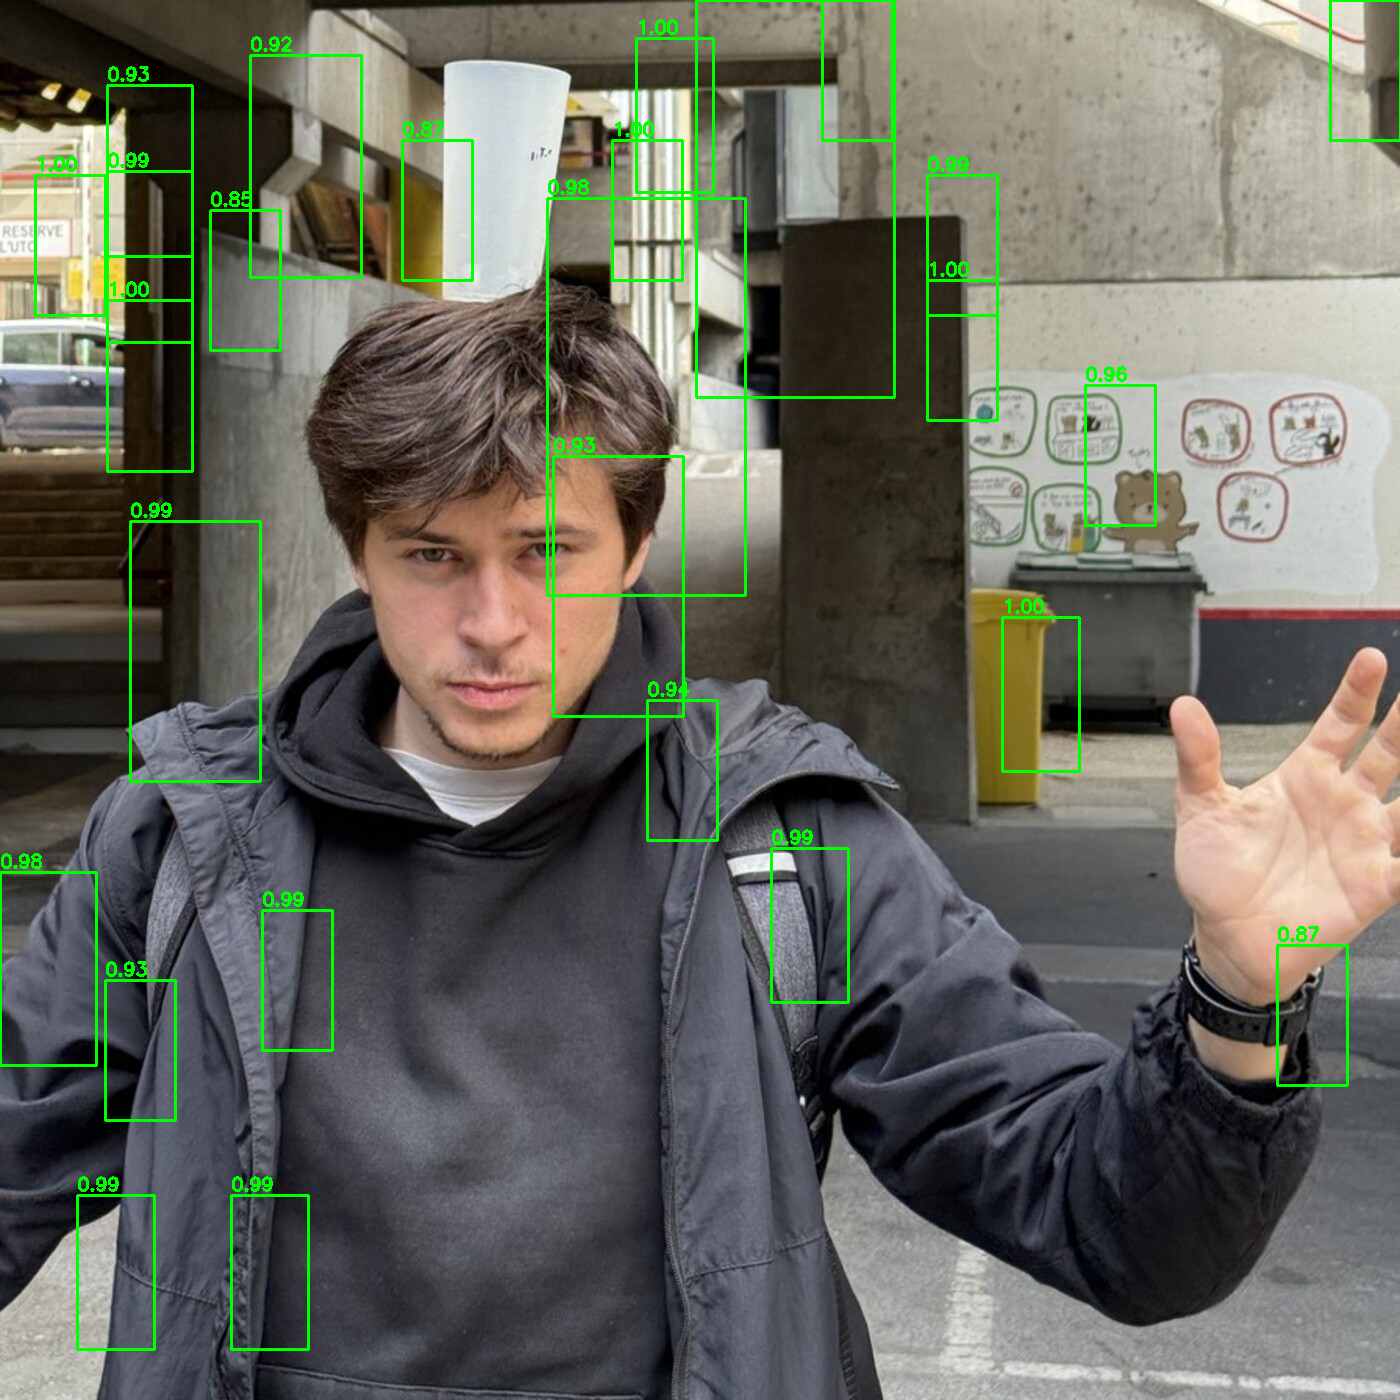

In [ ]:
import cv2
import joblib
import numpy as np
from skimage.feature import local_binary_pattern
from tqdm import tqdm

# ==============================================================================
# 1. HOGExtractor MULTICANAL + HSV + LBP
# ==============================================================================
class HOGExtractor:
    def __init__(self,
                 win_size=(64, 128),
                 block_size=(16, 16),
                 block_stride=(8, 8),
                 cell_size=(8, 8),
                 orientations=9,
                 h_bins=50,
                 s_bins=60,
                 lbp_P=8,
                 lbp_R=1):
        self.win_size = win_size
        self.block_size = block_size
        self.block_stride = block_stride
        self.cell_size = cell_size
        self.orientations = orientations
        self.h_bins = h_bins
        self.s_bins = s_bins
        self.lbp_P = lbp_P
        self.lbp_R = lbp_R

    def extract(self, img):
        img_resized = cv2.resize(img, self.win_size)

        # HOG sur chaque canal BGR
        hog_feats = []
        for ch in cv2.split(img_resized):
            f = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY) if False else ch
            feats = cv2.HOGDescriptor(_winSize=self.win_size,
                                      _blockSize=self.block_size,
                                      _blockStride=self.block_stride,
                                      _cellSize=self.cell_size,
                                      _nbins=self.orientations).compute(f)
            hog_feats.append(feats.flatten())
        hog_features = np.concatenate(hog_feats)

        # HSV histograms
        hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)
        h_hist = cv2.calcHist([hsv], [0], None, [self.h_bins], [0, 180]).flatten()
        s_hist = cv2.calcHist([hsv], [1], None, [self.s_bins], [0, 256]).flatten()
        h_hist /= (h_hist.sum() + 1e-7)
        s_hist /= (s_hist.sum() + 1e-7)
        hsv_features = np.concatenate([h_hist, s_hist])

        # LBP on gray
        gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        lbp = local_binary_pattern(gray, self.lbp_P, self.lbp_R, method='uniform')
        n_bins = int(lbp.max() + 1)
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
        lbp_hist = lbp_hist.astype(float) / (lbp_hist.sum() + 1e-7)

        return np.concatenate([hog_features, hsv_features, lbp_hist])


# ==============================================================================
# 2. Détection via pyramide d'images avec fenêtre fixe
# ==============================================================================
def detect_with_image_pyramid(
    image_path: str,
    svm_path: str,
    pca_path: str,
    scaler_path: str,
    score_threshold: float = 0.5,
    target_size=(128, 64),
    pyramid_scales_params=None
):
    # Chargement image
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Impossible de lire : {image_path}")
    h0, w0 = img.shape[:2]

    # Chargement modèles
    svm = joblib.load(svm_path)
    pca = joblib.load(pca_path)
    scaler = joblib.load(scaler_path)
    hog_ext = HOGExtractor(win_size=(target_size[1], target_size[0]))

    # Paramètres pyramide
    if pyramid_scales_params is None:
        pyramid_scales_params = {
            'r_h_min': 0.10, 'r_h_max': 0.50,
            'r_w_min': 0.05, 'r_w_max': 0.35,
            'num_scales': 10
        }
    Th, Tw = target_size
    p = pyramid_scales_params

    s_h_min = Th / (p['r_h_max'] * h0)
    s_h_max = Th / (p['r_h_min'] * h0)
    s_w_min = Tw / (p['r_w_max'] * w0)
    s_w_max = Tw / (p['r_w_min'] * w0)
    s_min, s_max = max(s_h_min, s_w_min), min(s_h_max, s_w_max)
    scales = list(np.linspace(s_min, s_max, p['num_scales'])) if s_min <= s_max else []

    stride_y, stride_x = Th // 4, Tw // 4
    detections = []

    for scale in tqdm(scales, desc="Échelles"):
        hs, ws = int(h0 * scale), int(w0 * scale)
        if hs < Th or ws < Tw:
            continue
        im_s = cv2.resize(img, (ws, hs))
        for y in range(0, hs - Th + 1, stride_y):
            for x in range(0, ws - Tw + 1, stride_x):
                patch = im_s[y:y+Th, x:x+Tw]
                feat = hog_ext.extract(patch).reshape(1, -1)
                feat_pca = pca.transform(feat)
                feat_s = scaler.transform(feat_pca)
                proba = svm.predict_proba(feat_s)[0][1]
                if proba >= score_threshold:
                    x0 = int(x / scale)
                    y0 = int(y / scale)
                    w_box = int(Tw / scale)
                    h_box = int(Th / scale)
                    detections.append({
                        'x': x0, 'y': y0, 'w': w_box, 'h': h_box,
                        'score': float(proba)
                    })

    return detections

# ==============================================================================
# 3. Exemple d'utilisation (adapté pour la nouvelle fonction)
# ==============================================================================
if __name__ == "__main__":
    IMAGE_PATH = "/content/drive/MyDrive/detection_ecocup_project/test/0038.jpg"
    SVM_PATH   = "/content/drive/MyDrive/detection_ecocup/svm_hog_hsv_lbp_pca550.joblib"
    PCA_PATH   = "/content/drive/MyDrive/detection_ecocup/pca_550.joblib"
    SCALER_PATH= "/content/drive/MyDrive/detection_ecocup/scaler_pca_550.joblib"


    # --- Appel de la NOUVELLE fonction ---
    dets = detect_with_image_pyramid(
        image_path=IMAGE_PATH,
        svm_path=SVM_PATH,
        pca_path=PCA_PATH,
        scaler_path=SCALER_PATH,
        score_threshold=0.8, # Seuil de confiance élevé pour commencer
        pyramid_scales_params={ # Vous pouvez ajuster ces paramètres
            'r_h_min': 0.10, 'r_h_max': 0.60, # Un peu plus large que l'augmentation
            'r_w_min': 0.05, 'r_w_max': 0.40,
            'num_scales': 10 # Plus d'échelles pour une détection plus fine
        }
    )

    # --- Le traitement NMS reste identique ---
    if not dets:
        print("\nAucune détection brute trouvée.")
    else:
        boxes = np.array([[d['x'], d['y'], d['x'] + d['w'], d['y'] + d['h']] for d in dets], dtype=np.float32)
        scores = np.array([d['score'] for d in dets])
        indices_nms = cv2.dnn.NMSBoxes(boxes.tolist(), scores.tolist(), score_threshold=0.8, nms_threshold=0.4)

        print(f"\n{len(dets)} détections brutes trouvées.")
        if len(indices_nms) > 0:
            print(f"{len(indices_nms)} détections finales après Non-Maximum Suppression :")
        else:
            print("Aucune détection finale après Non-Maximum Suppression.")

        # --- L'affichage des résultats reste identique ---
        img_vis = cv2.imread(IMAGE_PATH)
        if len(indices_nms) > 0:
            for i in indices_nms.flatten():
                d = dets[i]
                x, y, w, h = d['x'], d['y'], d['w'], d['h']
                score = d['score']
                cv2.rectangle(img_vis, (x, y), (x + w, y + h), (0, 255, 0), 2)
                label = f"{score:.2f}"
                cv2.putText(img_vis, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        output_path = "/content/drive/MyDrive/detection_ecocup_project/images_test/detection_result_pyramid.jpg"
        cv2.imwrite(output_path, img_vis)
        print(f"\nImage avec les détections sauvegardée ici : {output_path}")
        cv2_imshow(img_vis)

In [ ]:
# sliding_window_pyramid_batch.py

import cv2
import joblib
import numpy as np
import os
from pathlib import Path
from skimage.feature import hog
from tqdm import tqdm
# from google.colab.patches import cv2_imshow # Commenté car on sauvegarde seulement

# ==============================================================================
# 1. HOGExtractor RESTE IDENTIQUE
#    La fenêtre d'extraction est figée à (64, 128) comme prévu.
# ==============================================================================
class HOGExtractor:
    def __init__(self,
                 win_size=(64, 128),
                 block_size=(16, 16),
                 block_stride=(8, 8),
                 cell_size=(8, 8),
                 orientations=9):
        self.win_size = win_size
        self.block_size = block_size
        self.block_stride = block_stride
        self.cell_size = cell_size
        self.orientations = orientations

    def extract(self, img):
        # Redimensionne à 64x128 si ce n'est pas déjà le cas.
        # Dans la nouvelle logique, le patch sera déjà à la bonne taille,
        # mais cette ligne est une bonne sécurité.
        img_resized = cv2.resize(img, self.win_size)
        gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY) if img_resized.ndim == 3 else img_resized

        features = hog(
            gray,
            orientations=self.orientations,
            pixels_per_cell=self.cell_size,
            cells_per_block=(self.block_size[0] // self.cell_size[0],
                             self.block_size[1] // self.cell_size[1]),
            block_norm='L2-Hys',
            transform_sqrt=True,
            feature_vector=True
        )
        return features

# ==============================================================================
# 2. NOUVELLE Fonction de détection basées sur la pyramide d'images
#    Cette fonction remplace `sliding_window_detection`
# ==============================================================================
def detect_with_image_pyramid(
    image_path: str,
    svm_model,
    pca_model,
    scaler_model,
    hog_extractor,
    score_threshold: float = 0.5,
    # --- NOUVEAUX paramètres pour contrôler la pyramide, basés sur le script d'augmentation ---
    target_size=(128, 64),  # (H, W) de la fenêtre de détection fixe
    pyramid_scales_params={
        'r_h_min': 0.10, 'r_h_max': 0.50, # fenêtre/hauteur image originale
        'r_w_min': 0.05, 'r_w_max': 0.35, # fenêtre/largeur image originale
        'num_scales': 10  # Nombre de niveaux dans la pyramide (à ajuster)
    }
):
    """
    Détection d'objets via une pyramide d'images et une fenêtre glissante de taille fixe,
    pour correspondre à la logique de génération des données.
    """
    # --- Chargement de l'image ---
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Impossible de lire l'image : {image_path}")
    img_h_orig, img_w_orig = img.shape[:2]

    # --- NOUVEAU : Calcul des échelles de la pyramide ---
    # Cette logique est directement tirée de votre script `compute_scales`
    TARGET_H, TARGET_W = target_size
    params = pyramid_scales_params

    s_h_min = TARGET_H / (params['r_h_max'] * img_h_orig)
    s_h_max = TARGET_H / (params['r_h_min'] * img_h_orig)
    s_w_min = TARGET_W / (params['r_w_max'] * img_w_orig)
    s_w_max = TARGET_W / (params['r_w_min'] * img_w_orig)

    s_min = max(s_h_min, s_w_min)
    s_max = min(s_h_max, s_w_max)

    scales = []
    if s_min <= s_max:
        scales = list(np.linspace(s_min, s_max, params['num_scales']))

    # --- NOUVEAU : Définition du pas de glissement (stride) ---
    # Stride de 25% de la fenêtre (plus dense que les 50% de l'augmentation pour une meilleure détection)
    stride_y = TARGET_H // 4
    stride_x = TARGET_W // 4

    detections = []

    # --- NOUVEAU : Boucle sur la pyramide d'échelles ---
    for scale in scales:
        # Redimensionner l'image entière
        img_h_scaled, img_w_scaled = int(img_h_orig * scale), int(img_w_orig * scale)
        if img_h_scaled < TARGET_H or img_w_scaled < TARGET_W:
            continue # L'image redimensionnée est trop petite pour la fenêtre

        img_scaled = cv2.resize(img, (img_w_scaled, img_h_scaled))

        # --- Glisser la fenêtre de TAILLE FIXE sur l'image redimensionnée ---
        for y in range(0, img_h_scaled - TARGET_H + 1, stride_y):
            for x in range(0, img_w_scaled - TARGET_W + 1, stride_x):
                window = img_scaled[y:y+TARGET_H, x:x+TARGET_W]

                # --- Pipeline de prédiction complet (inchangé) ---
                # 1. Extraction HOG (sur un patch déjà en 128x64)
                feat = hog_extractor.extract(window)
                # 2. Transformation PCA
                feat_pca = pca_model.transform(feat.reshape(1, -1))
                # 3. Standardisation
                feat_scaled = scaler_model.transform(feat_pca)
                # 4. Prédiction SVM
                proba = svm_model.predict_proba(feat_scaled)[0][1]

                if proba >= score_threshold:
                    # --- NOUVEAU : Conversion des coordonnées ---
                    # Les coordonnées (x,y) sont sur l'image REDIMENSIONNÉE.
                    # Il faut les ramener à l'échelle de l'image ORIGINALE.
                    x_orig = int(x / scale)
                    y_orig = int(y / scale)
                    w_orig = int(TARGET_W / scale)
                    h_orig = int(TARGET_H / scale)

                    detections.append({
                        'x': x_orig, 'y': y_orig, 'w': w_orig, 'h': h_orig, 'score': float(proba)
                    })

    return detections

# ==============================================================================
# 3. NOUVELLE Fonction pour traiter toutes les images d'un dossier
# ==============================================================================
def process_all_images(
    input_folder: str,
    output_folder: str,
    svm_path: str,
    pca_path: str,
    scaler_path: str,
    score_threshold: float = 0.8,
    nms_threshold: float = 0.4,
    pyramid_scales_params=None
):
    """
    Traite toutes les images d'un dossier et sauvegarde les résultats de détection.
    """
    if pyramid_scales_params is None:
        pyramid_scales_params = {
            'r_h_min': 0.10, 'r_h_max': 0.60,
            'r_w_min': 0.05, 'r_w_max': 0.40,
            'num_scales': 5
        }

    # Créer le dossier de sortie s'il n'existe pas
    Path(output_folder).mkdir(parents=True, exist_ok=True)

    # Chargement des modèles une seule fois
    print("Chargement des modèles SVM, PCA, et Scaler...")
    svm_model = joblib.load(svm_path)
    pca_model = joblib.load(pca_path)
    scaler_model = joblib.load(scaler_path)
    hog_extractor = HOGExtractor(win_size=(64, 128))
    print("✔ Modèles chargés.")

    # Extensions d'images supportées
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}

    # Lister toutes les images dans le dossier d'entrée
    input_path = Path(input_folder)
    image_files = [f for f in input_path.iterdir()
                   if f.is_file() and f.suffix.lower() in image_extensions]

    if not image_files:
        print(f"Aucune image trouvée dans {input_folder}")
        return

    print(f"\nTraitement de {len(image_files)} images...")

    # Statistiques globales
    total_detections_raw = 0
    total_detections_final = 0
    successful_images = 0

    # Traiter chaque image
    for image_file in tqdm(image_files, desc="Images traitées"):
        try:
            image_path = str(image_file)

            # Détection sur l'image
            dets = detect_with_image_pyramid(
                image_path=image_path,
                svm_model=svm_model,
                pca_model=pca_model,
                scaler_model=scaler_model,
                hog_extractor=hog_extractor,
                score_threshold=score_threshold,
                pyramid_scales_params=pyramid_scales_params
            )

            total_detections_raw += len(dets)

            # Charger l'image pour la visualisation
            img_vis = cv2.imread(image_path)

            # Appliquer NMS si des détections sont trouvées
            final_detections = 0
            if dets:
                boxes = np.array([[d['x'], d['y'], d['x'] + d['w'], d['y'] + d['h']] for d in dets], dtype=np.float32)
                scores = np.array([d['score'] for d in dets])
                indices_nms = cv2.dnn.NMSBoxes(boxes.tolist(), scores.tolist(),
                                              score_threshold=score_threshold,
                                              nms_threshold=nms_threshold)

                # Dessiner les boîtes de détection finales
                if len(indices_nms) > 0:
                    final_detections = len(indices_nms)
                    for i in indices_nms.flatten():
                        d = dets[i]
                        x, y, w, h = d['x'], d['y'], d['w'], d['h']
                        score = d['score']
                        cv2.rectangle(img_vis, (x, y), (x + w, y + h), (0, 255, 0), 2)
                        label = f"{score:.2f}"
                        cv2.putText(img_vis, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            total_detections_final += final_detections

            # Sauvegarder l'image avec les détections
            output_filename = f"detection_{image_file.stem}.jpg"
            output_path = Path(output_folder) / output_filename
            cv2.imwrite(str(output_path), img_vis)

            successful_images += 1

        except Exception as e:
            print(f"\nErreur lors du traitement de {image_file.name}: {e}")
            continue

    # Afficher les statistiques finales
    print(f"\n{'='*60}")
    print(f"RÉSULTATS FINAUX:")
    print(f"{'='*60}")
    print(f"Images traitées avec succès: {successful_images}/{len(image_files)}")
    print(f"Total détections brutes: {total_detections_raw}")
    print(f"Total détections finales (après NMS): {total_detections_final}")
    print(f"Moyenne détections par image: {total_detections_final/successful_images:.2f}" if successful_images > 0 else "N/A")
    print(f"Images sauvegardées dans: {output_folder}")
    print(f"{'='*60}")

# ==============================================================================
# 4. Exemple d'utilisation pour traiter toutes les images positives
# ==============================================================================
if __name__ == "__main__":
    # Chemins à adapter selon votre structure
    INPUT_FOLDER = "/content/drive/MyDrive/detection_ecocup_project/test"
    OUTPUT_FOLDER = "/content/drive/MyDrive/detection_ecocup_project/train/detection_5"

    SVM_PATH = '/content/drive/MyDrive/detection_ecocup/svm_hog_pca458_retrained.joblib'
    PCA_PATH = '/content/drive/MyDrive/detection_ecocup/pca_458.joblib'
    SCALER_PATH = '/content/drive/MyDrive/detection_ecocup/scaler_pca_458.joblib'

    # Traitement de toutes les images
    process_all_images(
        input_folder=INPUT_FOLDER,
        output_folder=OUTPUT_FOLDER,
        svm_path=SVM_PATH,
        pca_path=PCA_PATH,
        scaler_path=SCALER_PATH,
        score_threshold=0.8, # Seuil de confiance
        nms_threshold=0.4,   # Seuil NMS
        pyramid_scales_params={
            'r_h_min': 0.10, 'r_h_max': 0.60,
            'r_w_min': 0.05, 'r_w_max': 0.40,
            'num_scales': 5
        }
    )

## detection avec rotation

In [ ]:
# sliding_window_pyramid_batch_with_rotation.py

import cv2
import joblib
import numpy as np
import os
from pathlib import Path
from skimage.feature import hog
from tqdm import tqdm

# ==============================================================================
# 1. HOGExtractor RESTE IDENTIQUE
#    La fenêtre d'extraction est figée à (64, 128) comme prévu.
# ==============================================================================
class HOGExtractor:
    def __init__(self,
                 win_size=(64, 128),
                 block_size=(16, 16),
                 block_stride=(8, 8),
                 cell_size=(8, 8),
                 orientations=9):
        self.win_size = win_size
        self.block_size = block_size
        self.block_stride = block_stride
        self.cell_size = cell_size
        self.orientations = orientations

    def extract(self, img):
        # Redimensionne à 64x128 si ce n'est pas déjà le cas.
        img_resized = cv2.resize(img, self.win_size)
        gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY) if img_resized.ndim == 3 else img_resized
        features = hog(
            gray,
            orientations=self.orientations,
            pixels_per_cell=self.cell_size,
            cells_per_block=(self.block_size[0] // self.cell_size[0],
                             self.block_size[1] // self.cell_size[1]),
            block_norm='L2-Hys',
            transform_sqrt=True,
            feature_vector=True
        )
        return features

# ==============================================================================
# 2. Détection via une pyramide d'images (mise à jour pour accepter image array)
# ==============================================================================
def detect_with_image_pyramid(
    image_input,            # Peut être un chemin (str) ou un array BGR
    svm_model,
    pca_model,
    scaler_model,
    hog_extractor,
    score_threshold: float = 0.5,
    target_size=(128, 64),   # (H, W) de la fenêtre de détection fixe
    pyramid_scales_params=None
):
    # Charger l'image si nécessaire
    if isinstance(image_input, str):
        img = cv2.imread(image_input)
    else:
        img = image_input.copy()
    if img is None:
        raise ValueError("Impossible de lire l'image d'entrée.")
    img_h_orig, img_w_orig = img.shape[:2]

    # Paramètres de la pyramide
    if pyramid_scales_params is None:
        pyramid_scales_params = {
            'r_h_min': 0.10, 'r_h_max': 0.60,
            'r_w_min': 0.05, 'r_w_max': 0.40,
            'num_scales': 5
        }
    TARGET_H, TARGET_W = target_size
    params = pyramid_scales_params

    # Calcul des échelles
    s_h_min = TARGET_H / (params['r_h_max'] * img_h_orig)
    s_h_max = TARGET_H / (params['r_h_min'] * img_h_orig)
    s_w_min = TARGET_W / (params['r_w_max'] * img_w_orig)
    s_w_max = TARGET_W / (params['r_w_min'] * img_w_orig)
    s_min = max(s_h_min, s_w_min)
    s_max = min(s_h_max, s_w_max)

    scales = []
    if s_min <= s_max:
        scales = list(np.linspace(s_min, s_max, params['num_scales']))

    # Stride de glissement de 25%
    stride_y = TARGET_H // 4
    stride_x = TARGET_W // 4

    detections = []
    # Boucle sur les échelles
    for scale in scales:
        h_scaled = int(img_h_orig * scale)
        w_scaled = int(img_w_orig * scale)
        if h_scaled < TARGET_H or w_scaled < TARGET_W:
            continue
        img_scaled = cv2.resize(img, (w_scaled, h_scaled))

        for y in range(0, h_scaled - TARGET_H + 1, stride_y):
            for x in range(0, w_scaled - TARGET_W + 1, stride_x):
                window = img_scaled[y:y+TARGET_H, x:x+TARGET_W]
                feat = hog_extractor.extract(window)
                feat_pca = pca_model.transform(feat.reshape(1, -1))
                feat_scaled = scaler_model.transform(feat_pca)
                proba = svm_model.predict_proba(feat_scaled)[0][1]

                if proba >= score_threshold:
                    x_orig = int(x / scale)
                    y_orig = int(y / scale)
                    w_orig = int(TARGET_W / scale)
                    h_orig = int(TARGET_H / scale)
                    detections.append({'x': x_orig, 'y': y_orig, 'w': w_orig, 'h': h_orig, 'score': float(proba)})
    return detections

# ==============================================================================
# 3. Traitement de toutes les images avec sauvegarde des versions originales et 180°
# ==============================================================================
def process_all_images(
    input_folder: str,
    output_folder: str,
    svm_path: str,
    pca_path: str,
    scaler_path: str,
    score_threshold: float = 0.8,
    nms_threshold: float = 0.4,
    pyramid_scales_params=None
):
    if pyramid_scales_params is None:
        pyramid_scales_params = {
            'r_h_min': 0.10, 'r_h_max': 0.60,
            'r_w_min': 0.05, 'r_w_max': 0.40,
            'num_scales': 5
        }

    Path(output_folder).mkdir(parents=True, exist_ok=True)

    # Chargement des modèles
    svm_model = joblib.load(svm_path)
    pca_model = joblib.load(pca_path)
    scaler_model = joblib.load(scaler_path)
    hog_extractor = HOGExtractor()

    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}
    image_files = [f for f in Path(input_folder).iterdir()
                   if f.is_file() and f.suffix.lower() in image_extensions]

    for image_file in tqdm(image_files, desc="Traitement des images"):
        try:
            img_path = str(image_file)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Impossible de lire {img_path}")
                continue

            # Deux versions: originale et 180°
            versions = [('orig', img), ('rot180', cv2.rotate(img, cv2.ROTATE_180))]
            for suffix, img_in in versions:
                dets = detect_with_image_pyramid(
                    img_in,
                    svm_model,
                    pca_model,
                    scaler_model,
                    hog_extractor,
                    score_threshold=score_threshold,
                    pyramid_scales_params=pyramid_scales_params
                )

                # Visualisation
                vis = img_in.copy()
                if dets:
                    boxes = np.array([[d['x'], d['y'], d['x']+d['w'], d['y']+d['h']] for d in dets], dtype=np.float32)
                    scores = [d['score'] for d in dets]
                    indices = cv2.dnn.NMSBoxes(boxes.tolist(), scores, score_threshold, nms_threshold)
                    if len(indices) > 0:
                        for i in indices.flatten():
                            d = dets[i]
                            x, y, w, h = d['x'], d['y'], d['w'], d['h']
                            cv2.rectangle(vis, (x, y), (x+w, y+h), (0,255,0), 2)
                            cv2.putText(vis, f"{d['score']:.2f}", (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

                out_name = f"detection_{suffix}_{image_file.stem}.jpg"
                cv2.imwrite(str(Path(output_folder) / out_name), vis)

        except Exception as e:
            print(f"Erreur sur {image_file.name}: {e}")
            continue

    print(f"Traitement terminé. Fichiers sauvegardés dans {output_folder}.")

# ==============================================================================
# 4. Exemple d'utilisation
# ==============================================================================
if __name__ == "__main__":
    INPUT_FOLDER = "/content/drive/MyDrive/detection_ecocup_project/test"
    OUTPUT_FOLDER = "/content/drive/MyDrive/detection_ecocup_project/train/detection_rot"
    SVM_PATH = '/content/drive/MyDrive/detection_ecocup/svm_hog_pca458_retrained.joblib'
    PCA_PATH = '/content/drive/MyDrive/detection_ecocup/pca_458.joblib'
    SCALER_PATH = '/content/drive/MyDrive/detection_ecocup/scaler_pca_458.joblib'

    process_all_images(
        input_folder=INPUT_FOLDER,
        output_folder=OUTPUT_FOLDER,
        svm_path=SVM_PATH,
        pca_path=PCA_PATH,
        scaler_path=SCALER_PATH,
        score_threshold=0.8,
        nms_threshold=0.4,
        pyramid_scales_params={
            'r_h_min': 0.10, 'r_h_max': 0.60,
            'r_w_min': 0.05, 'r_w_max': 0.40,
            'num_scales': 5
        }
    )

## Detection optimale finale

In [ ]:
import cv2
import joblib
import numpy as np
import os
from pathlib import Path
from skimage.feature import hog
from tqdm import tqdm

# ==================================================================
# 1. HOGExtractor RESTE IDENTIQUE
# ==================================================================
class HOGExtractor:
    def __init__(self,
                 win_size=(64, 128),
                 block_size=(16, 16),
                 block_stride=(8, 8),
                 cell_size=(8, 8),
                 orientations=9):
        self.win_size = win_size
        self.block_size = block_size
        self.block_stride = block_stride
        self.cell_size = cell_size
        self.orientations = orientations

    def extract(self, img):
        img_resized = cv2.resize(img, self.win_size)
        gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY) if img_resized.ndim == 3 else img_resized
        features = hog(
            gray,
            orientations=self.orientations,
            pixels_per_cell=self.cell_size,
            cells_per_block=(self.block_size[0] // self.cell_size[0],
                             self.block_size[1] // self.cell_size[1]),
            block_norm='L2-Hys',
            transform_sqrt=True,
            feature_vector=True
        )
        return features

# ==================================================================
# 2. Détection via pyramide d'images
# ==================================================================
def detect_with_image_pyramid(
    image_input,
    svm_model,
    pca_model,
    scaler_model,
    hog_extractor,
    score_threshold: float = 0.5,
    target_size=(128, 64),
    pyramid_scales_params=None
):
    if isinstance(image_input, str):
        img = cv2.imread(image_input)
    else:
        img = image_input.copy()
    if img is None:
        raise ValueError("Impossible de lire l'image d'entrée.")
    img_h_orig, img_w_orig = img.shape[:2]

    if pyramid_scales_params is None:
        pyramid_scales_params = {'r_h_min': 0.10, 'r_h_max': 0.60,
                                 'r_w_min': 0.05, 'r_w_max': 0.40,
                                 'num_scales': 5}
    TARGET_H, TARGET_W = target_size
    params = pyramid_scales_params

    # calcul des échelles
    s_h_min = TARGET_H / (params['r_h_max'] * img_h_orig)
    s_h_max = TARGET_H / (params['r_h_min'] * img_h_orig)
    s_w_min = TARGET_W / (params['r_w_max'] * img_w_orig)
    s_w_max = TARGET_W / (params['r_w_min'] * img_w_orig)
    s_min = max(s_h_min, s_w_min)
    s_max = min(s_h_max, s_w_max)

    scales = []
    if s_min <= s_max:
        scales = list(np.linspace(s_min, s_max, params['num_scales']))

    stride_y = TARGET_H // 4
    stride_x = TARGET_W // 4

    detections = []
    for scale in scales:
        h_scaled = int(img_h_orig * scale)
        w_scaled = int(img_w_orig * scale)
        if h_scaled < TARGET_H or w_scaled < TARGET_W:
            continue
        img_scaled = cv2.resize(img, (w_scaled, h_scaled))

        for y in range(0, h_scaled - TARGET_H + 1, stride_y):
            for x in range(0, w_scaled - TARGET_W + 1, stride_x):
                window = img_scaled[y:y+TARGET_H, x:x+TARGET_W]
                feat = hog_extractor.extract(window)
                feat_pca = pca_model.transform(feat.reshape(1, -1))
                feat_scaled = scaler_model.transform(feat_pca)
                proba = svm_model.predict_proba(feat_scaled)[0][1]

                if proba >= score_threshold:
                    x_orig = int(x / scale)
                    y_orig = int(y / scale)
                    w_orig = int(TARGET_W / scale)
                    h_orig = int(TARGET_H / scale)
                    detections.append({'x': x_orig, 'y': y_orig, 'w': w_orig, 'h': h_orig, 'score': float(proba)})
    return detections

# ==================================================================
# 3. Traitement de toutes les images
#    Génération des versions ORIG/ROT, + détection optimale finale
# ==================================================================
def process_all_images(
    input_folder: str,
    output_folder: str,
    final_output_folder: str,
    svm_path: str,
    pca_path: str,
    scaler_path: str,
    score_threshold: float = 0.8,
    nms_threshold: float = 0.4,
    pyramid_scales_params=None
):
    if pyramid_scales_params is None:
        pyramid_scales_params = {'r_h_min': 0.10, 'r_h_max': 0.60,
                                 'r_w_min': 0.05, 'r_w_max': 0.40,
                                 'num_scales': 5}

    Path(output_folder).mkdir(parents=True, exist_ok=True)
    final_folder = Path(final_output_folder)
    final_folder.mkdir(parents=True, exist_ok=True)

    detection_csv_path = final_folder / 'detection.csv'
    with open(detection_csv_path, 'w') as csv_file:
        csv_file.write('n,y,x,h,l,s\n')

    svm_model = joblib.load(svm_path)
    pca_model = joblib.load(pca_path)
    scaler_model = joblib.load(scaler_path)
    hog_extractor = HOGExtractor()

    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}
    image_files = [f for f in Path(input_folder).iterdir()
                   if f.is_file() and f.suffix.lower() in image_extensions]

    for image_file in tqdm(image_files, desc="Traitement des images"):
        try:
            img = cv2.imread(str(image_file))
            if img is None:
                print(f"Impossible de lire {image_file}")
                continue

            h_orig, w_orig = img.shape[:2]
            versions = [('orig', img), ('rot180', cv2.rotate(img, cv2.ROTATE_180))]
            results = {}
            for suffix, img_in in versions:
                dets = detect_with_image_pyramid(
                    img_in,
                    svm_model,
                    pca_model,
                    scaler_model,
                    hog_extractor,
                    score_threshold=score_threshold,
                    pyramid_scales_params=pyramid_scales_params
                )
                results[suffix] = dets

                # dessin des boîtes pour chaque version (optionnel)
                vis = img_in.copy()
                if dets:
                    boxes = np.array([[d['x'], d['y'], d['x']+d['w'], d['y']+d['h']] for d in dets], dtype=np.float32)
                    scores = [d['score'] for d in dets]
                    indices = cv2.dnn.NMSBoxes(boxes.tolist(), scores, score_threshold, nms_threshold)
                    if len(indices) > 0:
                        for i in indices.flatten():
                            d = dets[i]
                            cv2.rectangle(vis, (d['x'], d['y']), (d['x']+d['w'], d['y']+d['h']), (0,255,0), 2)
                            cv2.putText(vis, f"{d['score']:.2f}", (d['x'], d['y']-5),
                                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

                out_name = f"detection_{suffix}_{image_file.stem}.jpg"
                cv2.imwrite(str(Path(output_folder) / out_name), vis)

            # remapping des boîtes de la version rot180
            dets_orig = results.get('orig', [])
            dets_rot = results.get('rot180', [])
            mapped_rot = []
            for d in dets_rot:
                x_rot, y_rot, w_box, h_box = d['x'], d['y'], d['w'], d['h']
                x_m = w_orig - (x_rot + w_box)
                y_m = h_orig - (y_rot + h_box)
                mapped_rot.append({'x': int(x_m), 'y': int(y_m), 'w': w_box, 'h': h_box, 'score': d['score']})

            # fusion et NMS final
            combined = dets_orig + mapped_rot
            final_dets = []
            if combined:
                boxes = np.array([[d['x'], d['y'], d['x']+d['w'], d['y']+d['h']] for d in combined], dtype=np.float32)
                scores = [d['score'] for d in combined]
                indices = cv2.dnn.NMSBoxes(boxes.tolist(), scores, score_threshold, nms_threshold)
                if len(indices) > 0:
                    idxs = indices.flatten().tolist()
                    idxs = sorted(idxs, key=lambda i: scores[i], reverse=True)[:5]
                    final_dets = [combined[i] for i in idxs]

            # --- NOUVELLE ÉTAPE : suppression des boîtes entièrement contenues ---
            filtered = []
            for i, di in enumerate(final_dets):
                inside = False
                for j, dj in enumerate(final_dets):
                    if j != i:
                        if (di['x'] >= dj['x'] and
                            di['y'] >= dj['y'] and
                            di['x'] + di['w'] <= dj['x'] + dj['w'] and
                            di['y'] + di['h'] <= dj['y'] + dj['h']):
                            inside = True
                            break
                if not inside:
                    filtered.append(di)
            final_dets = filtered

            # dessin des boîtes finales optimales
            vis_final = img.copy()
            for d in final_dets:
                cv2.rectangle(vis_final, (d['x'], d['y']), (d['x']+d['w'], d['y']+d['h']), (0,0,255), 2)
                cv2.putText(vis_final, f"{d['score']:.2f}", (d['x'], d['y']-5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)

            final_name = f"detection_optimale_finale_{image_file.stem}.jpg"
            cv2.imwrite(str(final_folder / final_name), vis_final)

            # enregistrement CSV
            with open(detection_csv_path, 'a') as csv_file:
                for d in final_dets:
                    csv_file.write(f"{image_file.stem},{d['y']},{d['x']},{d['h']},{d['w']},{d['score']:.2f}\n")

        except Exception as e:
            print(f"Erreur sur {image_file.name}: {e}")
            continue

    print(f"Traitement terminé. Fichiers sauvegardés dans {output_folder} et {final_output_folder}.")

# ==================================================================
# 4. Exemple d'utilisation
# ==================================================================
if __name__ == "__main__":
    INPUT_FOLDER = "/content/drive/MyDrive/detection_ecocup_project/test"
    OUTPUT_FOLDER = "/content/drive/MyDrive/detection_ecocup_project/train/detection_rot2"
    FINAL_FOLDER = "/content/drive/MyDrive/detection_ecocup_project/train/detection_optimale_finale2"
    SVM_PATH = "/content/drive/MyDrive/detection_ecocup/svm_hog_pca458_retrained.joblib"
    PCA_PATH = "/content/drive/MyDrive/detection_ecocup/pca_458.joblib"
    SCALER_PATH = "/content/drive/MyDrive/detection_ecocup/scaler_pca_458.joblib"

    process_all_images(
        input_folder=INPUT_FOLDER,
        output_folder=OUTPUT_FOLDER,
        final_output_folder=FINAL_FOLDER,
        svm_path=SVM_PATH,
        pca_path=PCA_PATH,
        scaler_path=SCALER_PATH,
        score_threshold=0.8,
        nms_threshold=0.4,
        pyramid_scales_params={
            'r_h_min': 0.10, 'r_h_max': 0.60,
            'r_w_min': 0.05, 'r_w_max': 0.40,
            'num_scales': 5
        }
    )


Traitement des images:  29%|██▉       | 24/82 [51:07<1:56:37, 120.65s/it]

## Detection optimale finale : On ne garde qu'une boxpplot ou deux si score > 0.9

In [ ]:
import cv2
import joblib
import numpy as np
import os
from pathlib import Path
from skimage.feature import hog
from tqdm import tqdm

# ==================================================================
# 1. HOGExtractor (inchangé)
# ==================================================================
class HOGExtractor:
    def __init__(self,
                 win_size=(64, 128),
                 block_size=(16, 16),
                 block_stride=(8, 8),
                 cell_size=(8, 8),
                 orientations=9):
        self.win_size = win_size
        self.block_size = block_size
        self.block_stride = block_stride
        self.cell_size = cell_size
        self.orientations = orientations

    def extract(self, img):
        img_resized = cv2.resize(img, self.win_size)
        gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY) if img_resized.ndim == 3 else img_resized
        features = hog(
            gray,
            orientations=self.orientations,
            pixels_per_cell=self.cell_size,
            cells_per_block=(self.block_size[0] // self.cell_size[0],
                             self.block_size[1] // self.cell_size[1]),
            block_norm='L2-Hys',
            transform_sqrt=True,
            feature_vector=True
        )
        return features

# ==================================================================
# 2. Détection via pyramide d'images (inchangé)
# ==================================================================
def detect_with_image_pyramid(
    image_input,
    svm_model,
    pca_model,
    scaler_model,
    hog_extractor,
    score_threshold: float = 0.5,
    target_size=(128, 64),
    pyramid_scales_params=None
):
    if isinstance(image_input, str):
        img = cv2.imread(image_input)
    else:
        img = image_input.copy()
    if img is None:
        raise ValueError("Impossible de lire l'image d'entrée.")
    img_h_orig, img_w_orig = img.shape[:2]

    if pyramid_scales_params is None:
        pyramid_scales_params = {'r_h_min': 0.10, 'r_h_max': 0.60,
                                 'r_w_min': 0.05, 'r_w_max': 0.40,
                                 'num_scales': 5}
    TARGET_H, TARGET_W = target_size
    params = pyramid_scales_params

    # calcul des échelles
    s_h_min = TARGET_H / (params['r_h_max'] * img_h_orig)
    s_h_max = TARGET_H / (params['r_h_min'] * img_h_orig)
    s_w_min = TARGET_W / (params['r_w_max'] * img_w_orig)
    s_w_max = TARGET_W / (params['r_w_min'] * img_w_orig)
    s_min = max(s_h_min, s_w_min)
    s_max = min(s_h_max, s_w_max)

    scales = []
    if s_min <= s_max:
        scales = list(np.linspace(s_min, s_max, params['num_scales']))

    stride_y = TARGET_H // 4
    stride_x = TARGET_W // 4

    detections = []
    for scale in scales:
        h_scaled = int(img_h_orig * scale)
        w_scaled = int(img_w_orig * scale)
        if h_scaled < TARGET_H or w_scaled < TARGET_W:
            continue
        img_scaled = cv2.resize(img, (w_scaled, h_scaled))

        for y in range(0, h_scaled - TARGET_H + 1, stride_y):
            for x in range(0, w_scaled - TARGET_W + 1, stride_x):
                window = img_scaled[y:y+TARGET_H, x:x+TARGET_W]
                feat = hog_extractor.extract(window)
                feat_pca = pca_model.transform(feat.reshape(1, -1))
                feat_scaled = scaler_model.transform(feat_pca)
                proba = svm_model.predict_proba(feat_scaled)[0][1]

                if proba >= score_threshold:
                    x_orig = int(x / scale)
                    y_orig = int(y / scale)
                    w_orig = int(TARGET_W / scale)
                    h_orig = int(TARGET_H / scale)
                    detections.append({
                        'x': x_orig,
                        'y': y_orig,
                        'w': w_orig,
                        'h': h_orig,
                        'score': float(proba)
                    })
    return detections

# ==================================================================
# 3. Traitement de toutes les images
#    Génération ORIG/ROT + détection optimale modifiée
# ==================================================================
def process_all_images(
    input_folder: str,
    output_folder: str,
    final_output_folder: str,
    svm_path: str,
    pca_path: str,
    scaler_path: str,
    score_threshold: float = 0.8,
    nms_threshold: float = 0.4,
    pyramid_scales_params=None
):
    if pyramid_scales_params is None:
        pyramid_scales_params = {'r_h_min': 0.10, 'r_h_max': 0.60,
                                 'r_w_min': 0.05, 'r_w_max': 0.40,
                                 'num_scales': 5}

    Path(output_folder).mkdir(parents=True, exist_ok=True)
    final_folder = Path(final_output_folder)
    final_folder.mkdir(parents=True, exist_ok=True)

    detection_csv_path = final_folder / 'detection.csv'
    with open(detection_csv_path, 'w') as csv_file:
        csv_file.write('n,y,x,h,l,s\n')

    # Chargement des modèles
    svm_model = joblib.load(svm_path)
    pca_model = joblib.load(pca_path)
    scaler_model = joblib.load(scaler_path)
    hog_extractor = HOGExtractor()

    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}
    image_files = [f for f in Path(input_folder).iterdir()
                   if f.is_file() and f.suffix.lower() in image_extensions]

    for image_file in tqdm(image_files, desc="Traitement des images"):
        try:
            img = cv2.imread(str(image_file))
            if img is None:
                print(f"Impossible de lire {image_file}")
                continue

            h_orig, w_orig = img.shape[:2]
            # Versions ORIG et ROT180
            versions = [
                ('orig', img),
                ('rot180', cv2.rotate(img, cv2.ROTATE_180))
            ]
            results = {}
            for suffix, img_in in versions:
                dets = detect_with_image_pyramid(
                    img_in,
                    svm_model,
                    pca_model,
                    scaler_model,
                    hog_extractor,
                    score_threshold=score_threshold,
                    pyramid_scales_params=pyramid_scales_params
                )
                results[suffix] = dets

                # (optionnel) dessin des boîtes intermédiaires
                vis = img_in.copy()
                if dets:
                    boxes = np.array([[d['x'], d['y'], d['x']+d['w'], d['y']+d['h']]
                                      for d in dets], dtype=np.float32)
                    scores = [d['score'] for d in dets]
                    indices = cv2.dnn.NMSBoxes(boxes.tolist(), scores, score_threshold, nms_threshold)
                    if len(indices) > 0:
                        for i in indices.flatten():
                            d = dets[i]
                            cv2.rectangle(vis, (d['x'], d['y']), (d['x']+d['w'], d['y']+d['h']),
                                          (0,255,0), 2)
                            cv2.putText(vis, f"{d['score']:.2f}",
                                        (d['x'], d['y']-5),
                                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
                out_name = f"detection_{suffix}_{image_file.stem}.jpg"
                cv2.imwrite(str(Path(output_folder) / out_name), vis)

            # Mapping des boîtes ROT180
            dets_orig = results.get('orig', [])
            dets_rot = results.get('rot180', [])
            mapped_rot = []
            for d in dets_rot:
                x_rot, y_rot, w_box, h_box = d['x'], d['y'], d['w'], d['h']
                x_m = w_orig - (x_rot + w_box)
                y_m = h_orig - (y_rot + h_box)
                mapped_rot.append({'x': int(x_m), 'y': int(y_m),
                                   'w': w_box, 'h': h_box, 'score': d['score']})

            # Fusion et NMS final
            combined = dets_orig + mapped_rot
            final_dets = []
            if combined:
                boxes = np.array([[d['x'], d['y'], d['x']+d['w'], d['y']+d['h']]
                                  for d in combined], dtype=np.float32)
                scores = [d['score'] for d in combined]
                indices = cv2.dnn.NMSBoxes(boxes.tolist(), scores, score_threshold, nms_threshold)
                if len(indices) > 0:
                    idxs = indices.flatten().tolist()
                    # On limite d'abord à 5 par score décroissant
                    idxs = sorted(idxs, key=lambda i: scores[i], reverse=True)[:5]
                    final_dets = [combined[i] for i in idxs]

            # Suppression des boîtes entièrement contenues
            filtered = []
            for i, di in enumerate(final_dets):
                inside = False
                for j, dj in enumerate(final_dets):
                    if j != i:
                        if (di['x'] >= dj['x'] and
                            di['y'] >= dj['y'] and
                            di['x'] + di['w'] <= dj['x'] + dj['w'] and
                            di['y'] + di['h'] <= dj['y'] + dj['h']):
                            inside = True
                            break
                if not inside:
                    filtered.append(di)
            final_dets = filtered

            # --- NOUVELLE ÉTAPE : ne garder que la meilleure + optionnellement une 2ᵉ si > 0.9 ---
            final_dets = sorted(final_dets, key=lambda d: d['score'], reverse=True)
            selection = []
            if final_dets:
                # on garde toujours la boîte la mieux notée
                selection.append(final_dets[0])
                # on garde la 2ᵉ seulement si son score > 0.9
                if len(final_dets) > 1 and final_dets[1]['score'] > 0.9:
                    selection.append(final_dets[1])
            final_dets = selection

            # Dessin et enregistrement des boîtes finales optimales réduites
            vis_final = img.copy()
            for d in final_dets:
                cv2.rectangle(vis_final, (d['x'], d['y']), (d['x']+d['w'], d['y']+d['h']), (0,0,255), 2)
                cv2.putText(vis_final, f"{d['score']:.2f}", (d['x'], d['y']-5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)

            final_name = f"detection_optimale_finale_{image_file.stem}.jpg"
            cv2.imwrite(str(Path(final_output_folder) / final_name), vis_final)

            # Enregistrement CSV
            with open(detection_csv_path, 'a') as csv_file:
                for d in final_dets:
                    csv_file.write(f"{image_file.stem},{d['y']},{d['x']},{d['h']},{d['w']},{d['score']:.2f}\n")

        except Exception as e:
            print(f"Erreur sur {image_file.name}: {e}")
            continue

    print(f"Traitement terminé. Fichiers sauvegardés dans {output_folder} et {final_output_folder}.")

# ==================================================================
# 4. Exemple d'utilisation
# ==================================================================

if __name__ == "__main__":
    DRIVE = "/content/drive/MyDrive"

    # Dossiers d’entrée / sortie
    INPUT_FOLDER  = f"{DRIVE}/detection_ecocup_project/test"
    OUTPUT_FOLDER = f"{DRIVE}/detection_ecocup_project/train/detection_rot2"
    FINAL_FOLDER  = f"{DRIVE}/detection_ecocup_project/train/detection_optimale_finale2"

    # Chemins vers les modèles recalculés avec HOG+HSV+LBP et PCA à 300 composantes
    PCA_COMPONENTS = 550
    SVM_PATH    = f"{DRIVE}/detection_ecocup/svm_hog_hsv_lbp_pca{PCA_COMPONENTS}.joblib"
    PCA_PATH    = f"{DRIVE}/detection_ecocup/pca_{PCA_COMPONENTS}.joblib"
    SCALER_PATH = f"{DRIVE}/detection_ecocup/scaler_pca_{PCA_COMPONENTS}.joblib"

    process_all_images(
        input_folder=INPUT_FOLDER,
        output_folder=OUTPUT_FOLDER,
        final_output_folder=FINAL_FOLDER,
        svm_path=SVM_PATH,
        pca_path=PCA_PATH,
        scaler_path=SCALER_PATH,
        score_threshold=0.8,
        nms_threshold=0.4,
        pyramid_scales_params={
            'r_h_min': 0.10, 'r_h_max': 0.60,
            'r_w_min': 0.05, 'r_w_max': 0.40,
            'num_scales': 5
        }
    )



In [ ]:
import pandas as pd

# Charger le CSV
path = "/content/drive/MyDrive/detection_ecocup_project/train/detection_optimale_finale/detection.csv"
df = pd.read_csv(path, sep="\t" if "\t" in open(path).readline() else ",")

# Vérifier les colonnes (corriger si nécessaire)
df.columns = df.columns.str.strip()  # Nettoyage des noms de colonnes

# Filtrage : pour chaque 'n', garder les lignes avec le s max
df_filtered = df[df.groupby('n')['s'].transform('max') == df['s']]

# Sauvegarder le résultat
output_path = "/content/drive/MyDrive/detection_ecocup_project/train/detection_optimale_finale/detection_post_traitement.csv"
df_filtered.to_csv(output_path, index=False)

print("Fichier filtré enregistré dans :", output_path)



Fichier filtré enregistré dans : /content/drive/MyDrive/detection_ecocup_project/train/detection_optimale_finale/detection_post_traitement.csv


# Fentre glissante Avec la recherche séléctive

In [ ]:
import cv2
import joblib
import numpy as np
import os
from pathlib import Path
from skimage.feature import hog
from tqdm import tqdm
# ==============================================================================
# 1. HOGExtractor RESTE IDENTIQUE
#    La fenêtre d'extraction est figée à (64, 128) comme prévu.
# ======================================================================
class HOGExtractor:
    def __init__(self,
                 win_size=(64, 128),
                 block_size=(16, 16),
                 block_stride=(8, 8),
                 cell_size=(8, 8),
                 orientations=9):
        self.win_size = win_size
        self.block_size = block_size
        self.block_stride = block_stride
        self.cell_size = cell_size
        self.orientations = orientations

    def extract(self, img):
        # Redimensionne à 64x128 si ce n'est pas déjà le cas.
        img_resized = cv2.resize(img, self.win_size)
        gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY) if img_resized.ndim == 3 else img_resized

        features = hog(
            gray,
            orientations=self.orientations,
            pixels_per_cell=self.cell_size,
            cells_per_block=(self.block_size[0] // self.cell_size[0],
                             self.block_size[1] // self.cell_size[1]),
            block_norm='L2-Hys',
            transform_sqrt=True,
            feature_vector=True
        )
        return features

# ==============================================================================
# 2. FONCTION DE RECHERCHE SELECTIVE
#    Extrait des régions candidates via Selective Search d'OpenCV
# ======================================================================
def get_selective_search_regions(img, mode='fast'):
    """
    Extrait les propositions de régions par Selective Search.
    mode: 'fast' (rapide, moins précis) ou 'quality' (plus lent, plus précis)
    """
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    if mode == 'fast':
        ss.switchToSelectiveSearchFast()
    else:
        ss.switchToSelectiveSearchQuality()
    rects = ss.process()
    # rects: liste de [x, y, w, h]
    return rects

# ==============================================================================
# 3. NOUVELLE FONCTION DE DÉTECTION PAR RECHERCHE SÉLECTIVE
# ======================================================================
def detect_with_selective_search(
    image_path: str,
    svm_model,
    pca_model,
    scaler_model,
    hog_extractor,
    score_threshold: float = 0.5,
    max_regions: int = 2000,
    min_size: int = 20,
    search_mode: str = 'fast'
):
    """
    Détection d'objets via Selective Search + HOG+SVM.
    - Génère jusqu'à max_regions propositions
    - Filtre par taille minimale
    - Applique HOG, PCA, scaler, SVM
    """
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Impossible de lire l'image : {image_path}")
    img_h, img_w = img.shape[:2]

    # Propositions de régions
    rects = get_selective_search_regions(img, mode=search_mode)

    detections = []
    # On limite le nombre de propositions à traiter
    for (x, y, w, h) in rects[:max_regions]:
        # Filtrer par taille minimale
        if w < min_size or h < min_size:
            continue
        window = img[y:y+h, x:x+w]
        # Pipeline de prédiction
        feat = hog_extractor.extract(window)
        feat_pca = pca_model.transform(feat.reshape(1, -1))
        feat_scaled = scaler_model.transform(feat_pca)
        proba = svm_model.predict_proba(feat_scaled)[0][1]
        if proba >= score_threshold:
            detections.append({'x': x, 'y': y, 'w': w, 'h': h, 'score': float(proba)})
    return detections

# ==============================================================================
# 4. FONCTION EXISTANTE DE PYRAMIDE + FENÊTRE GLISSANTE (INCHANGÉE)
# ======================================================================
# (Conserver detect_with_image_pyramid de la version initiale sans modification)

# ==============================================================================
# 5. Traitement de toutes les images avec choix de la méthode
# ======================================================================
def process_all_images(
    input_folder: str,
    output_folder: str,
    svm_path: str,
    pca_path: str,
    scaler_path: str,
    score_threshold: float = 0.8,
    nms_threshold: float = 0.4,
    detection_method: str = 'selective_search',  # 'sliding_window' ou 'selective_search'
    pyramid_scales_params=None,
    ss_mode: str = 'fast',
    ss_max_regions: int = 2000,
    ss_min_size: int = 20
):
    """
    Traite toutes les images d'un dossier et sauvegarde les résultats.
    detection_method: choix de la méthode de génération des candidats.
    """
    if pyramid_scales_params is None:
        pyramid_scales_params = {
            'r_h_min': 0.10, 'r_h_max': 0.60,
            'r_w_min': 0.05, 'r_w_max': 0.40,
            'num_scales': 5
        }

    Path(output_folder).mkdir(parents=True, exist_ok=True)

    # Chargement des modèles
    svm_model = joblib.load(svm_path)
    pca_model = joblib.load(pca_path)
    scaler_model = joblib.load(scaler_path)
    hog_extractor = HOGExtractor(win_size=(64, 128))

    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}
    image_files = [f for f in Path(input_folder).iterdir()
                   if f.is_file() and f.suffix.lower() in image_extensions]
    if not image_files:
        print(f"Aucune image trouvée dans {input_folder}")
        return

    total_raw = total_final = success = 0
    for img_file in tqdm(image_files, desc="Images traitées"):
        try:
            path = str(img_file)
            if detection_method == 'selective_search':
                dets = detect_with_selective_search(
                    path, svm_model, pca_model, scaler_model,
                    hog_extractor, score_threshold,
                    max_regions=ss_max_regions,
                    min_size=ss_min_size,
                    search_mode=ss_mode
                )
            else:
                dets = detect_with_image_pyramid(
                    image_path=path,
                    svm_model=svm_model,
                    pca_model=pca_model,
                    scaler_model=scaler_model,
                    hog_extractor=hog_extractor,
                    score_threshold=score_threshold,
                    pyramid_scales_params=pyramid_scales_params
                )

            total_raw += len(dets)
            img_vis = cv2.imread(path)

            final_count = 0
            if dets:
                boxes = np.array([[d['x'], d['y'], d['x']+d['w'], d['y']+d['h']] for d in dets], dtype=np.float32)
                scores = np.array([d['score'] for d in dets])
                inds = cv2.dnn.NMSBoxes(boxes.tolist(), scores.tolist(), score_threshold, nms_threshold)
                if len(inds) > 0:
                    final_count = len(inds)
                    for i in inds.flatten():
                        d = dets[i]
                        cv2.rectangle(img_vis, (d['x'], d['y']), (d['x']+d['w'], d['y']+d['h']), (0,255,0), 2)
                        cv2.putText(img_vis, f"{d['score']:.2f}", (d['x'], d['y']-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
            total_final += final_count
            cv2.imwrite(str(Path(output_folder)/f"det_{img_file.stem}.jpg"), img_vis)
            success += 1
        except Exception as e:
            print(f"Erreur {img_file.name}: {e}")
            continue

    print(f"Traité: {success}/{len(image_files)}, brut: {total_raw}, après NMS: {total_final}")

# ==============================================================================
# 6. Exemple d'utilisation pour traiter toutes les images positives
# ==============================================================================
if __name__ == "__main__":
    # Chemins à adapter selon votre structure
    INPUT_FOLDER = "/content/drive/MyDrive/detection_ecocup_project/test"
    OUTPUT_FOLDER = "/content/drive/MyDrive/detection_ecocup_project/train/detection_2"

    SVM_PATH = '/content/drive/MyDrive/detection_ecocup/svm_hog_pca458_final.joblib'
    PCA_PATH = '/content/drive/MyDrive/detection_ecocup/pca_458.joblib'
    SCALER_PATH = '/content/drive/MyDrive/detection_ecocup/scaler_pca_458.joblib'

    # Traitement de toutes les images
    process_all_images(
        input_folder=INPUT_FOLDER,
        output_folder=OUTPUT_FOLDER,
        svm_path=SVM_PATH,
        pca_path=PCA_PATH,
        scaler_path=SCALER_PATH,
        score_threshold=0.8, # Seuil de confiance
        nms_threshold=0.4,   # Seuil NMS
        detection_method='selective_search',
        pyramid_scales_params={
            'r_h_min': 0.10, 'r_h_max': 0.60,
            'r_w_min': 0.05, 'r_w_max': 0.40,
            'num_scales': 5
        },
        ss_mode='fast',
        ss_max_regions=1500,
        ss_min_size=20
    )

# Haar + Adaboost

# Detecteur, fenetre glissante et recherche sélective

In [ ]:
# Maintenant il faut utiliser le modele SVM /content/drive/MyDrive/detection_ecocup/svm_hog_pca458_model.joblib pour faire une fenetre glissante et appliquer un detecteur aux donnée train /content/drive/MyDrive/detection_ecocup_project/train/images


# Task
Explain the provided Python code for object detection using HOG features and an SVM classifier, and provide the complete code.

## Load necessary components

### Subtask:
Load the trained SVM model (including PCA and StandardScaler), the HOG extractor configuration, and the necessary libraries (OpenCV, numpy, joblib, etc.).


**Reasoning**:
Import necessary libraries and define the HOGExtractor class.



In [ ]:
import os
import cv2
import joblib
import numpy as np
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt

**Reasoning**:
Define the model path and load the trained SVM model using joblib.



In [ ]:
# Define the path to the trained model
model_path = '/content/drive/MyDrive/detection_ecocup/svm_hog_pca458_model.joblib'

# Load the trained model
model = joblib.load(model_path)
print(f"Model loaded successfully from: {model_path}")